In [1]:
# include all top level packages
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from fem.plots import format_for_paper
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# setup format
format_for_paper()

In [2]:
    # # Return results
    # return {
    #     "kappa_true": true_kappa, # true kappa
    #     "kappa_recovered": kappa_recovered, # recovered kappa
    #     "kappa_final_rel_error": kappa_final_rel_l2_error, # relative L2 error in kappa
    #     "ukappa_true": ukappa, # true solution
    #     "ukappa_measured": u_meas, # measured solution
    #     "ukappa_recovered": u_recovered, # recovered solution
    #     # --- Final Errors ---
    #     "ukappa_recovered_rel_error": u_error_final_rel_l2, # relative L2 error in recovered solution and true solution
    #     "ukappa_recovered_rel_error_meas": u_error_final_rel_l2_meas, # relative L2 error in recovered solution and measured solution
    #     # --- Iterate Errors ---
    #     "ukappa_iterates_error": u_kappa_l2_errors, # L2 error in recovered solution and true solution at each iteration
    #     "ukappa_iterates_error_meas": u_meas_l2_errors, # L2 error in recovered solution and measured solution at each iteration 
    #     "ukappa_iterates_rel_errors": u_kappa_rel_l2_errors, # relative L2 error in recovered solution and true solution at each iteration
    #     "ukappa_iterates_errors": u_kappa_l2_errors, # L2 error in recovered solution and true solution at each iteration
    #     "ukappa_iterates_rel_errors_meas": u_meas_rel_l2_errors, # relative L2 error in recovered solution and measured solution at each iteration
    #     "ukappa_iterates_errors_meas": u_meas_l2_errors, # L2 error in recovered solution and measured solution at each iteration
    #     "kappa_iterates_rel_errors": kappa_rel_l2_errors, # relative L2 error in kappa at each iteration
    #     # --- Iteration Metrics ---
    #     "iterations": len(iterations), # number of iterations
    #     "total_optimization_time": total_optimization_time, # total optimization time
    #     "objectives": objectives, # objective values at each iteration
    #     "reg_values": reg_values, # regularization values at each iteration
    #     "best_reg_value": best_reg_value, # best regularization value
    # }

In [3]:
# # load npz file
# results = np.load("../results/analysis/results-denoiser-1e-5.npz", allow_pickle=True)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

iterative_metrics = [
    "kappa_iterates_rel_errors", "ukappa_iterates_rel_errors",
    "ukappa_iterates_rel_errors_meas", "objectives", "reg_values",
]
final_metrics = [
    "kappa_final_rel_error", "ukappa_recovered_rel_error",
    "ukappa_recovered_rel_error_meas", "total_optimization_time", "iterations",
    # Add keys for calculated metrics if needed here or calculate later
    "kappa_abs_l2", "u_abs_l2_true", "u_abs_l2_meas"
]

regularizer_names = ["L2", "tv", "denoiser"]
current_lambda = '1e-5' # Or load dynamically

# --- Initialize the final nested dictionary ---
all_metrics_data = {reg_name: {metric: [] for metric in final_metrics + iterative_metrics} for reg_name in regularizer_names}
# Store padded arrays separately if needed for iterative plots
all_padded_iterative_arrays = {reg_name: {} for reg_name in regularizer_names}


# --- Loop through each regularizer ---
for regularizer_name in regularizer_names:
    print(f"\nProcessing Regularizer: {regularizer_name} for lambda={current_lambda}")
    try:
        results = np.load(f"../results/analysis/results-{regularizer_name}-{current_lambda}.npz", allow_pickle=True)
    except FileNotFoundError:
        print(f"  Warning: File not found. Skipping.")
        continue

    run_keys = list(results.keys())
    num_runs = len(run_keys)

    # --- Data storage specific to this regularizer ---
    # These lists will hold data ONLY for the current regularizer runs
    local_iterative_data = {metric: [] for metric in iterative_metrics}
    local_final_data = {metric: [] for metric in final_metrics}
    local_iteration_counts = []

    max_iterations = 0
    # --- Loop through runs for the CURRENT regularizer ---
    for key in run_keys:
        try:
            run_data = results[key].item()
            if not isinstance(run_data, dict): continue

            # --- Process iterations for padding ---
            iterations_this_run = run_data.get("iterations")
            # ... (rest of your iteration counting logic) ...
            iter_list_len = len(run_data.get("kappa_iterates_rel_errors", []))
            if iterations_this_run is None:
                iterations_this_run = iter_list_len
                if iter_list_len == 0 and "objectives" in run_data:
                    iterations_this_run = len(run_data.get("objectives", []))
            if iterations_this_run is not None and iterations_this_run > 0:
                local_iteration_counts.append(iterations_this_run)
                max_iterations = max(max_iterations, iterations_this_run)
            else: continue # Skip if no iterations

            # --- Extract iterative data into local lists ---
            for metric in iterative_metrics:
                if metric in run_data:
                    # Append a COPY of the list/array if it's mutable, though list() often suffices for 1D
                    local_iterative_data[metric].append(list(run_data[metric]))
                else:
                    local_iterative_data[metric].append(None) # Placeholder for padding

            # --- Extract final data into local lists ---
            for metric in final_metrics:
                 # Handle direct extraction
                 if metric not in ["kappa_abs_l2", "u_abs_l2_true", "u_abs_l2_meas"]:
                     local_final_data[metric].append(run_data.get(metric, np.nan))
                 else:
                     local_final_data[metric].append(np.nan) # Placeholder for calculation

            # --- Calculate final absolute L2 errors for THIS run ---
            kappa_true = run_data.get("kappa_true")
            kappa_rec = run_data.get("kappa_recovered")
            # ... (Your L2 calculation logic) ...
            if isinstance(kappa_true, np.ndarray) and isinstance(kappa_rec, np.ndarray) and kappa_true.shape == kappa_rec.shape:
                 local_final_data["kappa_abs_l2"][-1] = np.linalg.norm(kappa_rec - kappa_true) # Update last NaN

            u_true = run_data.get("ukappa_true")
            u_rec = run_data.get("ukappa_recovered")
            u_meas = run_data.get("ukappa_measured")
            if isinstance(u_true, np.ndarray) and isinstance(u_rec, np.ndarray) and u_true.shape == u_rec.shape:
                 local_final_data["u_abs_l2_true"][-1] = np.linalg.norm(u_rec - u_true)
            if isinstance(u_meas, np.ndarray) and isinstance(u_rec, np.ndarray) and u_meas.shape == u_rec.shape:
                 local_final_data["u_abs_l2_meas"][-1] = np.linalg.norm(u_rec - u_meas)


        except Exception as e:
            print(f"  Error processing run {key} for {regularizer_name}: {e}. Skipping run.")
            # Need to handle appending NaNs consistently if a run fails mid-extraction


    # --- Store final metrics for this regularizer ---
    # Now, local_final_data contains all results for the current regularizer
    for metric in final_metrics:
         all_metrics_data[regularizer_name][metric].extend(local_final_data[metric])


    # --- Perform Padding for Iterative data for this regularizer ---
    if max_iterations > 0:
        print(f"  Padding iterative data for {regularizer_name} (Max Iter: {max_iterations})")
        iterations_axis = np.arange(1, max_iterations + 1)
        padded_arrays_for_reg = {}
        for metric in iterative_metrics:
            # ... (Your padding logic using local_iterative_data[metric] and local_iteration_counts) ...
            padded_data = []
            run_index = 0
            for i, data_list in enumerate(local_iterative_data[metric]):
                 if data_list is not None:
                      current_run_iterations = local_iteration_counts[run_index]
                      padding_needed = max_iterations - current_run_iterations
                      if padding_needed >= 0:
                           padded_list = data_list + [np.nan] * padding_needed
                           padded_list = padded_list[:max_iterations] # Ensure exact length
                      else: # Should not happen if max_iterations is correct
                           padded_list = data_list[:max_iterations]

                      if len(padded_list) != max_iterations: # Safety check
                            padded_list = (padded_list + [np.nan] * max_iterations)[:max_iterations]

                      padded_data.append(padded_list)
                      run_index += 1
                 else: # Metric was missing for this run
                      padded_data.append([np.nan] * max_iterations)
                      if i < len(local_iteration_counts): run_index +=1

            if padded_data:
                 padded_arrays_for_reg[metric] = np.array(padded_data, dtype=np.float64)

        # Store the padded arrays for this regularizer
        all_padded_iterative_arrays[regularizer_name] = padded_arrays_for_reg
    else:
         print(f"  No valid runs found for {regularizer_name}. Skipping padding.")


# --- Now use all_metrics_data and all_padded_iterative_arrays for analysis/plotting ---
print("\n--- Data Extraction Complete ---")
# Example check:
print("Length of L2 kappa errors:", len(all_metrics_data['L2']['kappa_final_rel_error']))
print("Length of Denoiser kappa errors:", len(all_metrics_data['denoiser']['kappa_final_rel_error']))

# Calculate difference (should not be zero now if data differs)
diff = np.array(all_metrics_data['denoiser']['kappa_final_rel_error']) - np.array(all_metrics_data['L2']['kappa_final_rel_error'])
print("Difference sample (first 5):", diff[:5])
print("Mean difference:", np.nanmean(diff)) # Use nanmean in case of NaNs



Processing Regularizer: L2 for lambda=1e-5
  Padding iterative data for L2 (Max Iter: 3000)

Processing Regularizer: tv for lambda=1e-5
  Padding iterative data for tv (Max Iter: 1981)

Processing Regularizer: denoiser for lambda=1e-5
  Padding iterative data for denoiser (Max Iter: 695)

--- Data Extraction Complete ---
Length of L2 kappa errors: 100
Length of Denoiser kappa errors: 100
Difference sample (first 5): [-0.21788703 -0.2665586  -0.24603496 -0.21623283 -0.2191056 ]
Mean difference: -0.21822610097334572


Saving figure to ../figures/iterates/denoiser-1e-5/solution_error_true.pdf


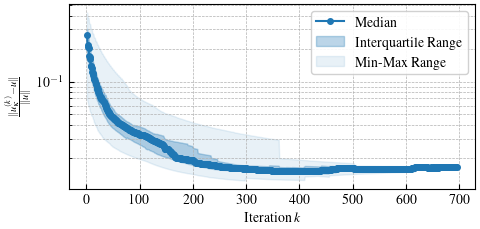

Saving figure to ../figures/iterates/denoiser-1e-5/solution_error_measured.pdf


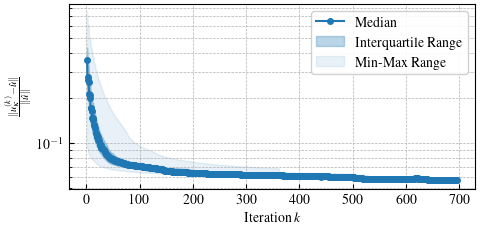

Saving figure to ../figures/iterates/denoiser-1e-5/kappa_error.pdf


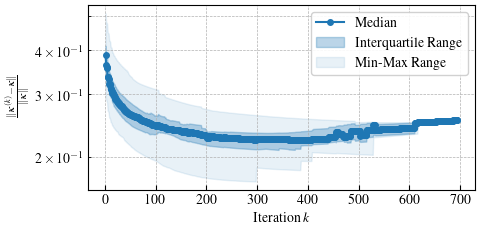

Saving figure to ../figures/iterates/denoiser-1e-5/objective_function.pdf


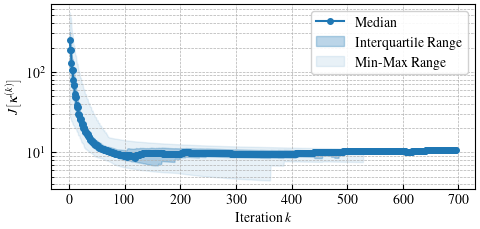

Saving figure to ../figures/iterates/denoiser-1e-5/regularization.pdf


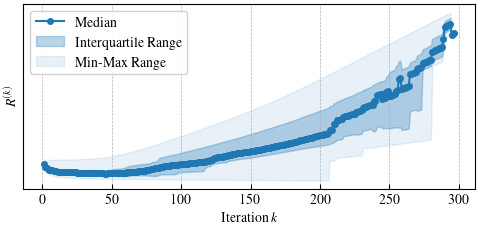

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

# Set up matplotlib for publication quality
mpl.rcParams.update({
    # 'font.family': 'serif',
    # 'font.serif': ['Times New Roman', 'DejaVu Serif', 'Times', 'Computer Modern Roman'],
    # 'font.size': 16,
    # 'axes.labelsize': 16,
    # 'axes.titlesize': 16,
    # 'xtick.labelsize': 14,
    # 'ytick.labelsize': 14,
    # 'legend.fontsize': 16,
    # 'figure.titlesize': 18,
    # 'figure.dpi': 300,
    # 'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'text.usetex': True,  # Enable LaTeX rendering
    'text.latex.preamble': r'\usepackage{amsmath}',
})

# Continue with data extraction
padded_iterative_arrays = all_padded_iterative_arrays['denoiser']

# Now create separate figures for each metric 
plot_configs = [
    # Solution error plots
    {
        "metric": "ukappa_iterates_rel_errors", 
        # "title": "Solution Relative Error vs. True Solution",
        "ylabel": r"$\frac{\|u_{\kappa}^{(k)} - u\|}{\|u\|}$",
        "filename": "../figures/iterates/denoiser-1e-5/solution_error_true.pdf",
        "figsize": (5, 2.5)
    },
    {
        "metric": "ukappa_iterates_rel_errors_meas", 
        # "title": "Solution Relative Error vs. Measured Solution",
        "ylabel": r"$\frac{\|u_{\kappa}^{(k)} - \hat{u}\|}{\|\hat{u}\|}$",
        "filename": "../figures/iterates/denoiser-1e-5/solution_error_measured.pdf",
        "figsize": (5, 2.5)
    },
    # Parameter error plot
    {
        "metric": "kappa_iterates_rel_errors", 
        # "title": "Parameter Relative Error",
        "ylabel": r"$\frac{\|\kappa^{(k)} - \kappa\|}{\|\kappa\|}$",
        "filename": "../figures/iterates/denoiser-1e-5/kappa_error.pdf",
        "figsize": (5, 2.5)
    },
    # Objective function plot
    {
        "metric": "objectives", 
        # "title": "Objective Function Value",
        "ylabel": r"$J[\kappa^{(k)}]$",
        "filename": "../figures/iterates/denoiser-1e-5/objective_function.pdf", 
        "figsize": (5, 2.5)
    },
    # Regularization parameter plot
    {
        "metric": "reg_values", 
        # "title": "Regularization Value",
        "ylabel": r"$R^{(k)}$",
        "filename": "../figures/iterates/denoiser-1e-5/regularization.pdf",
        "figsize": (5, 2.5)
    }
]

# Generate individual plots
for config in plot_configs:
    metric = config["metric"]
    
    # Skip if this metric is not in our data
    if metric not in padded_iterative_arrays:
        print(f"Skipping {metric}: Not found in data.")
        continue
        
    data_array = padded_iterative_arrays[metric]
    if data_array.size == 0: 
        print(f"Skipping {metric}: Empty data array.")
        continue
    
    # Check for columns/iterations with valid data
    valid_iterations_mask = ~np.all(np.isnan(data_array), axis=0)
    current_iterations_axis = iterations_axis[valid_iterations_mask]
    
    if len(current_iterations_axis) == 0:
        print(f"Skipping {metric}: No valid data points after padding.")
        continue
        
    # Calculate statistics
    median_vals = np.nanmedian(data_array[:, valid_iterations_mask], axis=0)
    q1_vals = np.nanpercentile(data_array[:, valid_iterations_mask], 25, axis=0)
    q3_vals = np.nanpercentile(data_array[:, valid_iterations_mask], 75, axis=0)
    min_vals = np.nanmin(data_array[:, valid_iterations_mask], axis=0)
    max_vals = np.nanmax(data_array[:, valid_iterations_mask], axis=0)
    
    # Create figure
    fig, ax = plt.figure(figsize=config["figsize"]), plt.gca()
    
    # Plot median with quartiles
    ax.plot(current_iterations_axis, median_vals, 'o-', color='#1f77b4', 
            linewidth=1.5, markersize=4, label='Median')
    ax.fill_between(current_iterations_axis, q1_vals, q3_vals, 
                    color='#1f77b4', alpha=0.3, label='Interquartile Range')
    
    # Add min-max range for broader perspective (optional)
    ax.fill_between(current_iterations_axis, min_vals, max_vals, 
                    color='#1f77b4', alpha=0.1, label='Min-Max Range')
    
    # Set labels with proper math notation
    ax.set_xlabel('Iteration $k$')
    ax.set_ylabel(config["ylabel"])
    ax.set_yticks([])
    # ax.set_title(config["title"])
    
    # Use log scale for error metrics and objectives
    if 'error' in metric.lower() or 'objective' in metric.lower():
        if np.nanmin(median_vals) > 0:
            ax.set_yscale('log')
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        else:
            print(f"Warning: Non-positive values in {metric}. Using linear scale.")
            ax.grid(True, linestyle='--', linewidth=0.5)
    else:
        ax.grid(True, linestyle='--', linewidth=0.5)
    
    # Add legend
    ax.legend(loc='best', frameon=True, framealpha=0.9)
    
    # # Add annotations
    # n_valid_runs = np.sum(~np.isnan(data_array[:, 0]))
    # plt.figtext(0.01, 0.01, f'Based on {n_valid_runs} valid runs', 
    #             fontsize=8, ha='left')
    
    # Make ticks inward
    ax.tick_params(direction='in', which='both')
    
    plt.tight_layout()
    
    # Save figure (optional - comment out if not needed)
    savepath = Path(config["filename"])
    if not savepath.exists():
        os.makedirs(savepath.parent, exist_ok=True)
    print(f"Saving figure to {savepath}")
    plt.savefig(savepath)
    
    plt.show()

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
import os
from pathlib import Path
import warnings

# --- Configuration ---
regularizer_names = ["L2", "tv", "denoiser"]
current_lambda = '1e-5' # Or load dynamically

iterative_metrics = [
    "kappa_iterates_rel_errors", "ukappa_iterates_rel_errors",
    "ukappa_iterates_rel_errors_meas", "objectives", "reg_values",
]
final_metrics = [
    "kappa_final_rel_error", "ukappa_recovered_rel_error",
    "ukappa_recovered_rel_error_meas", "total_optimization_time", "iterations",
    "kappa_abs_l2", "u_abs_l2_true", "u_abs_l2_meas" # Include calculated ones
]

# --- Step 1: Data Extraction & Finding Global Max Iterations ---
print("--- Step 1: Extracting Data and Finding Global Max Iterations ---")

# Store raw data before padding
all_raw_iterative_data = {reg: {metric: [] for metric in iterative_metrics} for reg in regularizer_names}
all_final_metrics_data = {reg: {metric: [] for metric in final_metrics} for reg in regularizer_names}
all_iteration_counts_by_reg = {reg: [] for reg in regularizer_names}
global_max_iter = 0

for regularizer_name in regularizer_names:
    print(f"  Processing Regularizer: {regularizer_name}")
    file_path = f"../results/analysis/results-{regularizer_name}-{current_lambda}.npz"
    try:
        results = np.load(file_path, allow_pickle=True)
    except FileNotFoundError:
        print(f"    Warning: File not found: {file_path}. Skipping.")
        continue

    run_keys = list(results.keys())
    print(f"    Found {len(run_keys)} runs.")

    for key in run_keys:
        try:
            run_data = results[key].item()
            if not isinstance(run_data, dict): continue

            # --- Get Iteration Count ---
            iterations_this_run = run_data.get("iterations")
            # Fallback logic for iteration count
            iter_list_len = len(run_data.get("kappa_iterates_rel_errors", []))
            if iterations_this_run is None:
                iterations_this_run = iter_list_len
                if iter_list_len == 0 and "objectives" in run_data:
                    iterations_this_run = len(run_data.get("objectives", []))

            if iterations_this_run is None or iterations_this_run <= 0:
                print(f"    Warning: Could not determine valid iteration count for run {key}. Skipping run.")
                continue

            # --- Update Global Max Iter and Store Count ---
            global_max_iter = max(global_max_iter, iterations_this_run)
            all_iteration_counts_by_reg[regularizer_name].append(iterations_this_run)

            # --- Extract Raw Iterative Data ---
            for metric in iterative_metrics:
                if metric in run_data:
                    # Make sure data length matches reported iterations
                    metric_data = run_data[metric]
                    if len(metric_data) == iterations_this_run:
                         all_raw_iterative_data[regularizer_name][metric].append(list(metric_data))
                    else:
                         print(f"    Warning: Length mismatch for {metric} in run {key} ({len(metric_data)} vs {iterations_this_run}). Appending None.")
                         all_raw_iterative_data[regularizer_name][metric].append(None) # Mark as invalid for padding
                else:
                    all_raw_iterative_data[regularizer_name][metric].append(None) # Placeholder

            # --- Extract/Calculate Final Metrics ---
            for metric in final_metrics:
                 if metric not in ["kappa_abs_l2", "u_abs_l2_true", "u_abs_l2_meas"]:
                      all_final_metrics_data[regularizer_name][metric].append(run_data.get(metric, np.nan))
                 else:
                      all_final_metrics_data[regularizer_name][metric].append(np.nan) # Placeholder

            kappa_true = run_data.get("kappa_true")
            kappa_rec = run_data.get("kappa_recovered")
            if isinstance(kappa_true, np.ndarray) and isinstance(kappa_rec, np.ndarray) and kappa_true.shape == kappa_rec.shape:
                 all_final_metrics_data[regularizer_name]["kappa_abs_l2"][-1] = np.linalg.norm(kappa_rec - kappa_true)

            u_true = run_data.get("ukappa_true")
            u_rec = run_data.get("ukappa_recovered")
            u_meas = run_data.get("ukappa_measured")
            if isinstance(u_true, np.ndarray) and isinstance(u_rec, np.ndarray) and u_true.shape == u_rec.shape:
                 all_final_metrics_data[regularizer_name]["u_abs_l2_true"][-1] = np.linalg.norm(u_rec - u_true)
            if isinstance(u_meas, np.ndarray) and isinstance(u_rec, np.ndarray) and u_meas.shape == u_rec.shape:
                 all_final_metrics_data[regularizer_name]["u_abs_l2_meas"][-1] = np.linalg.norm(u_rec - u_meas)

        except Exception as e:
            print(f"    Error processing run {key} for {regularizer_name}: {e}. Skipping run.")
            # Attempt to add None placeholders to keep lists potentially aligned, though filtering later is safer
            run_idx = len(all_iteration_counts_by_reg[regularizer_name]) -1 # Index of potentially failed run
            for metric in iterative_metrics:
                 if len(all_raw_iterative_data[regularizer_name][metric]) == run_idx : all_raw_iterative_data[regularizer_name][metric].append(None)
            for metric in final_metrics:
                 if len(all_final_metrics_data[regularizer_name][metric]) == run_idx : all_final_metrics_data[regularizer_name][metric].append(np.nan)


if global_max_iter == 0:
    raise ValueError("Could not find any valid runs or determine global max iterations.")
print(f"\nGlobal Max Iterations Found: {global_max_iter}")
iterations_axis = np.arange(1, global_max_iter + 1)

# --- Step 2: Padding Data to Global Max Iterations ---
print("\n--- Step 2: Padding Iterative Data ---")
all_padded_iterative_arrays = {reg: {} for reg in regularizer_names}

for regularizer_name in regularizer_names:
    print(f"  Padding for {regularizer_name} up to {global_max_iter} iterations...")
    if not all_iteration_counts_by_reg[regularizer_name]: # Skip if no runs were valid
        print(f"    Skipping padding for {regularizer_name}, no valid runs found.")
        continue

    for metric in iterative_metrics:
        padded_data = []
        run_index = 0 # Tracks index in the iteration_counts list for this regularizer
        raw_metric_lists = all_raw_iterative_data[regularizer_name][metric]

        # Check if the number of data lists matches the number of iteration counts recorded
        if len(raw_metric_lists) != len(all_iteration_counts_by_reg[regularizer_name]):
             print(f"    Warning: Mismatch in data list length ({len(raw_metric_lists)}) vs iteration count ({len(all_iteration_counts_by_reg[regularizer_name])}) for {metric}. Skipping padding for this metric.")
             all_padded_iterative_arrays[regularizer_name][metric] = np.empty((0, global_max_iter)) # Assign empty array
             continue

        for data_list in raw_metric_lists:
            # data_list corresponds to the run at run_index
            if data_list is not None: # Check if data was valid for this run/metric
                current_run_iterations = all_iteration_counts_by_reg[regularizer_name][run_index]
                padding_needed = global_max_iter - current_run_iterations

                if padding_needed >= 0:
                    # Pad with NaNs if shorter than global_max_iter
                    padded_list = data_list + [np.nan] * padding_needed
                    # Ensure correct length (handles potential data > iterations mismatch)
                    padded_list = padded_list[:global_max_iter]
                else:
                    # Should not happen if global_max_iter is correct, but truncate just in case
                    padded_list = data_list[:global_max_iter]

                # Final safety check for length
                if len(padded_list) != global_max_iter:
                    padded_list = (padded_list + [np.nan] * global_max_iter)[:global_max_iter]

                padded_data.append(padded_list)
            else:
                # If metric data was missing or invalid for this run, pad entirely with NaNs
                padded_data.append([np.nan] * global_max_iter)

            run_index += 1 # Increment for next run

        if padded_data:
            try:
                all_padded_iterative_arrays[regularizer_name][metric] = np.array(padded_data, dtype=np.float64)
            except ValueError as e:
                 print(f"    Error converting padded data to array for {metric}, {regularizer_name}: {e}. Lengths might be inconsistent.")
                 all_padded_iterative_arrays[regularizer_name][metric] = np.empty((0, global_max_iter)) # Assign empty array
        else:
             all_padded_iterative_arrays[regularizer_name][metric] = np.empty((0, global_max_iter)) # Assign empty array if no runs had this metric


# --- Step 3: Plotting (Using Correctly Padded Data) ---
print("\n--- Step 3: Generating Iterative Plots ---")

# Base directory for iterative plots
base_output_dir = Path("../figures/iterates")

# --- Plotting Configurations (Define once) ---
plot_configs = [
    { "metric": "ukappa_iterates_rel_errors", "ylabel": r"$\frac{\|u_{\kappa}^{(k)} - u\|}{\|u\|}$", "base_filename": "solution_error_true.pdf", "figsize": (5, 2.5) },
    { "metric": "ukappa_iterates_rel_errors_meas", "ylabel": r"$\frac{\|u_{\kappa}^{(k)} - \hat{u}\|}{\|\hat{u}\|}$", "base_filename": "solution_error_measured.pdf", "figsize": (5, 2.5) },
    { "metric": "kappa_iterates_rel_errors", "ylabel": r"$\frac{\|\kappa^{(k)} - \kappa\|}{\|\kappa\|}$", "base_filename": "kappa_error.pdf", "figsize": (5, 2.5) },
    { "metric": "objectives", "ylabel": r"$J[\kappa^{(k)}]$", "base_filename": "objective_function.pdf", "figsize": (5, 2.5) },
    { "metric": "reg_values", "ylabel": r"$R^{(k)}$", "base_filename": "regularization.pdf", "figsize": (5, 2.5) }
]

# --- Use Publication Quality Settings ---
mpl.rcParams.update({
    # 'font.family': 'serif',
    # ... (rest of your mpl settings) ...
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
})

# --- Outer loop through regularizers ---
for regularizer_name in regularizer_names:
    print(f"\n--- Generating plots for Regularizer: {regularizer_name} ---")

    if regularizer_name not in all_padded_iterative_arrays:
        print(f"  Padded data for {regularizer_name} not found. Skipping plots.")
        continue
    padded_iterative_arrays = all_padded_iterative_arrays[regularizer_name]

    reg_output_dir = base_output_dir / f"{regularizer_name}-{current_lambda}"
    os.makedirs(reg_output_dir, exist_ok=True)

    # --- Inner loop for plotting each metric ---
    for config in plot_configs:
        metric = config["metric"]
        base_filename = config["base_filename"]
        savepath = reg_output_dir / base_filename

        if metric not in padded_iterative_arrays:
            print(f"  Skipping metric '{metric}' for {regularizer_name}: Not found in padded data.")
            continue

        data_array = padded_iterative_arrays[metric]

        # --- Shape Check (SHOULD PASS NOW) ---
        if not isinstance(data_array, np.ndarray) or data_array.ndim != 2:
            print(f"  Skipping metric '{metric}' for {regularizer_name}: Data is not a 2D numpy array.")
            continue
        if data_array.shape[1] != global_max_iter:
             # This check should ideally not fail anymore if padding worked
             print(f"  ERROR: PADDING FAILED for {metric}, {regularizer_name}. Shape is {data_array.shape}, expected (runs, {global_max_iter}). Skipping plot.")
             continue
        # --- End Shape Check ---

        if data_array.size == 0:
            print(f"  Skipping metric '{metric}' for {regularizer_name}: Empty data array after padding.")
            continue

        with warnings.catch_warnings():
             warnings.simplefilter("ignore", category=RuntimeWarning)
             valid_iterations_mask = ~np.all(np.isnan(data_array), axis=0)
        current_iterations_axis = iterations_axis[valid_iterations_mask]

        if len(current_iterations_axis) == 0:
            print(f"  Skipping metric '{metric}' for {regularizer_name}: No valid (non-NaN) data points.")
            continue

        # Calculate statistics
        try:
            with warnings.catch_warnings():
                 warnings.simplefilter("ignore", category=RuntimeWarning)
                 median_vals = np.nanmedian(data_array[:, valid_iterations_mask], axis=0)
                 q1_vals = np.nanpercentile(data_array[:, valid_iterations_mask], 25, axis=0)
                 q3_vals = np.nanpercentile(data_array[:, valid_iterations_mask], 75, axis=0)
                 min_vals = np.nanmin(data_array[:, valid_iterations_mask], axis=0)
                 max_vals = np.nanmax(data_array[:, valid_iterations_mask], axis=0)
        except Exception as e:
            print(f"  Error calculating stats for {metric}, {regularizer_name}: {e}. Skipping plot.")
            continue

        # --- Plotting Logic (same as before) ---
        fig, ax = plt.figure(figsize=config["figsize"]), plt.gca()
        ax.plot(current_iterations_axis, median_vals, 'o-', color='#1f77b4', lw=1.5, ms=4, label='Median')
        ax.fill_between(current_iterations_axis, q1_vals, q3_vals, color='#1f77b4', alpha=0.3, label='Interquartile Range')
        ax.fill_between(current_iterations_axis, min_vals, max_vals, color='#1f77b4', alpha=0.1, label='Min-Max Range')
        ax.set_xlabel('Iteration $k$')
        ax.set_ylabel(config["ylabel"])
        ax.set_yticks([])
        if 'error' in metric.lower() or 'objective' in metric.lower():
            if np.any(median_vals > 0):
                 min_positive_median = np.min(median_vals[median_vals > 0]) if np.any(median_vals > 0) else 1
                 ax.set_ylim(bottom=min_positive_median * 0.5) # Added safety factor
                 ax.set_yscale('log')
                 ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            else:
                 print(f"  Warning: Non-positive values for {metric}, {regularizer_name}. Using linear scale.")
                 ax.grid(True, linestyle='--', linewidth=0.5)
        else:
            ax.grid(True, linestyle='--', linewidth=0.5)
        ax.legend(loc='best', frameon=True, framealpha=0.9)
        ax.tick_params(direction='in', which='both')
        plt.tight_layout()

        # --- Save figure ---
        try:
            plt.savefig(savepath)
            print(f"  Saved figure: {savepath}")
        except Exception as e:
            print(f"  Error saving figure {savepath}: {e}")
        plt.close(fig)

print("\n--- Finished generating iterative plots for all regularizers ---")

--- Step 1: Extracting Data and Finding Global Max Iterations ---
  Processing Regularizer: L2
    Found 100 runs.
  Processing Regularizer: tv
    Found 100 runs.
  Processing Regularizer: denoiser
    Found 100 runs.

Global Max Iterations Found: 3000

--- Step 2: Padding Iterative Data ---
  Padding for L2 up to 3000 iterations...
  Padding for tv up to 3000 iterations...
  Padding for denoiser up to 3000 iterations...

--- Step 3: Generating Iterative Plots ---

--- Generating plots for Regularizer: L2 ---
  Saved figure: ../figures/iterates/L2-1e-5/solution_error_true.pdf
  Saved figure: ../figures/iterates/L2-1e-5/solution_error_measured.pdf
  Saved figure: ../figures/iterates/L2-1e-5/kappa_error.pdf
  Saved figure: ../figures/iterates/L2-1e-5/objective_function.pdf
  Skipping metric 'reg_values' for L2: No valid (non-NaN) data points.

--- Generating plots for Regularizer: tv ---
  Saved figure: ../figures/iterates/tv-1e-5/solution_error_true.pdf
  Saved figure: ../figures/itera

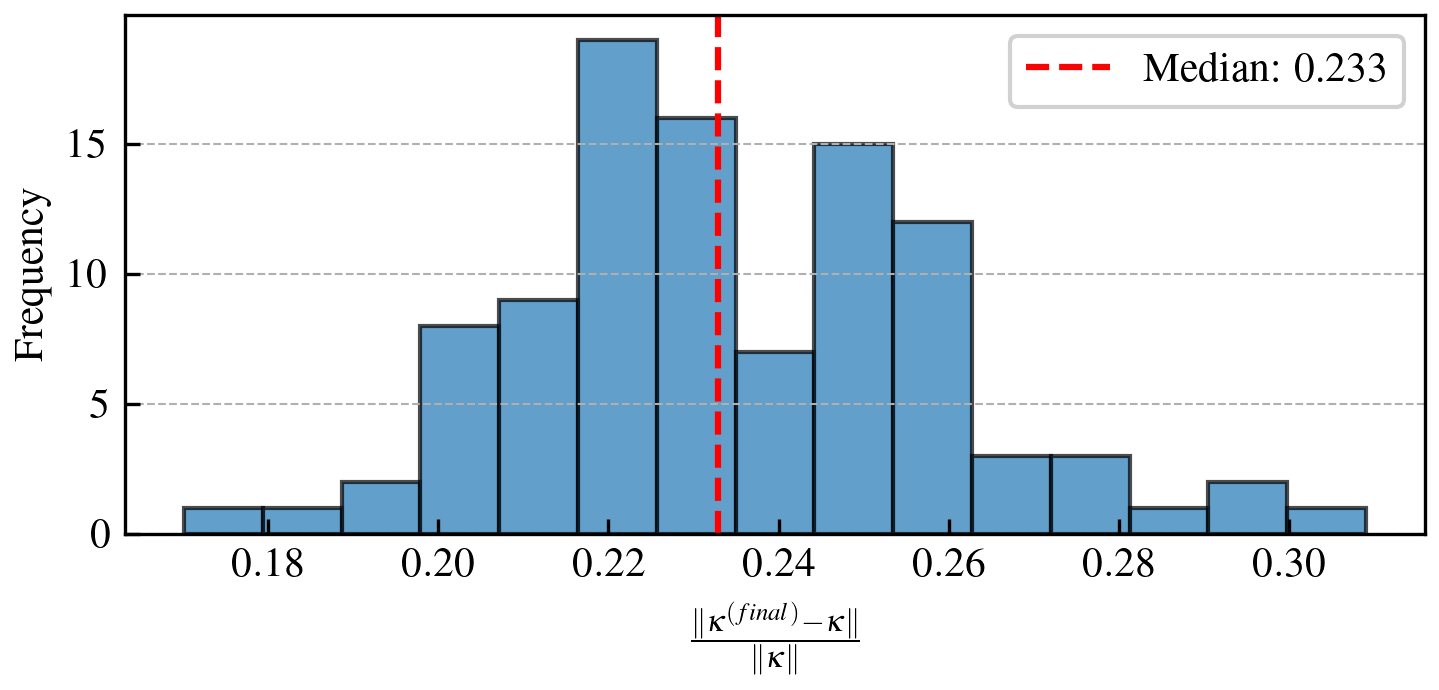

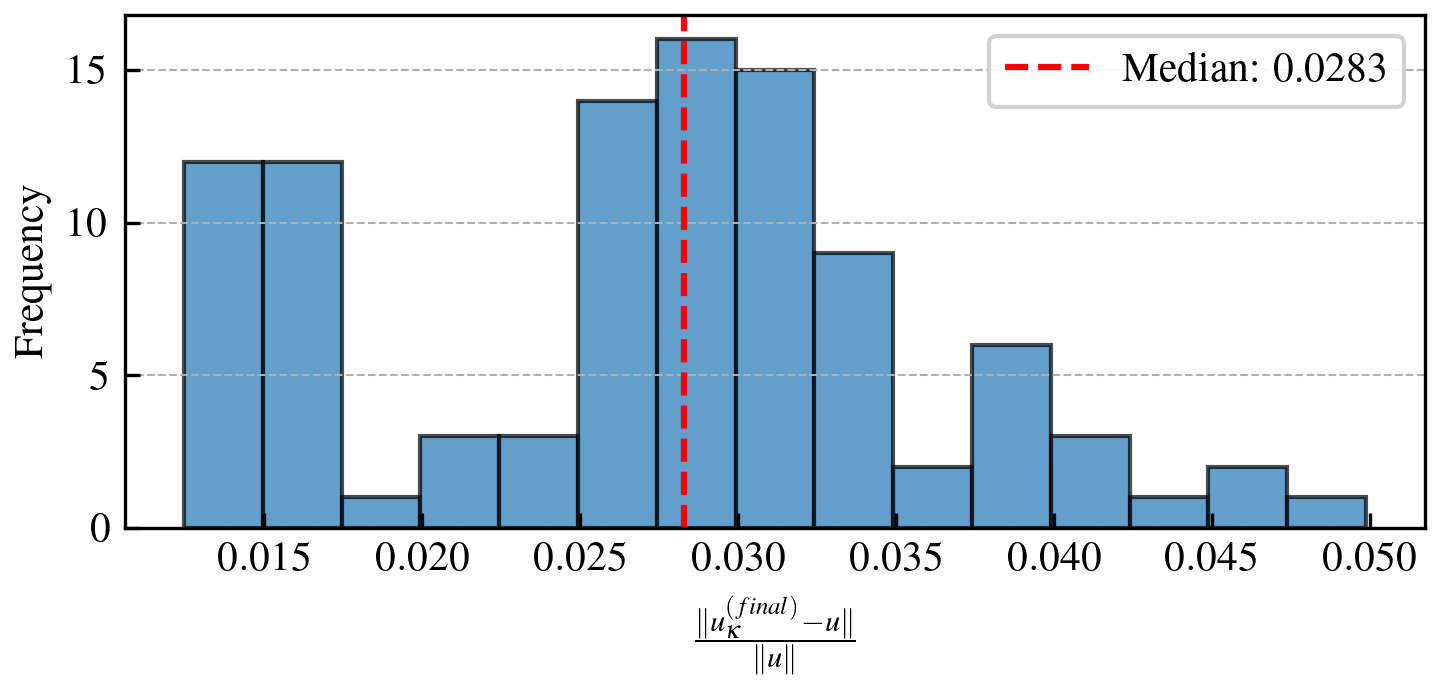

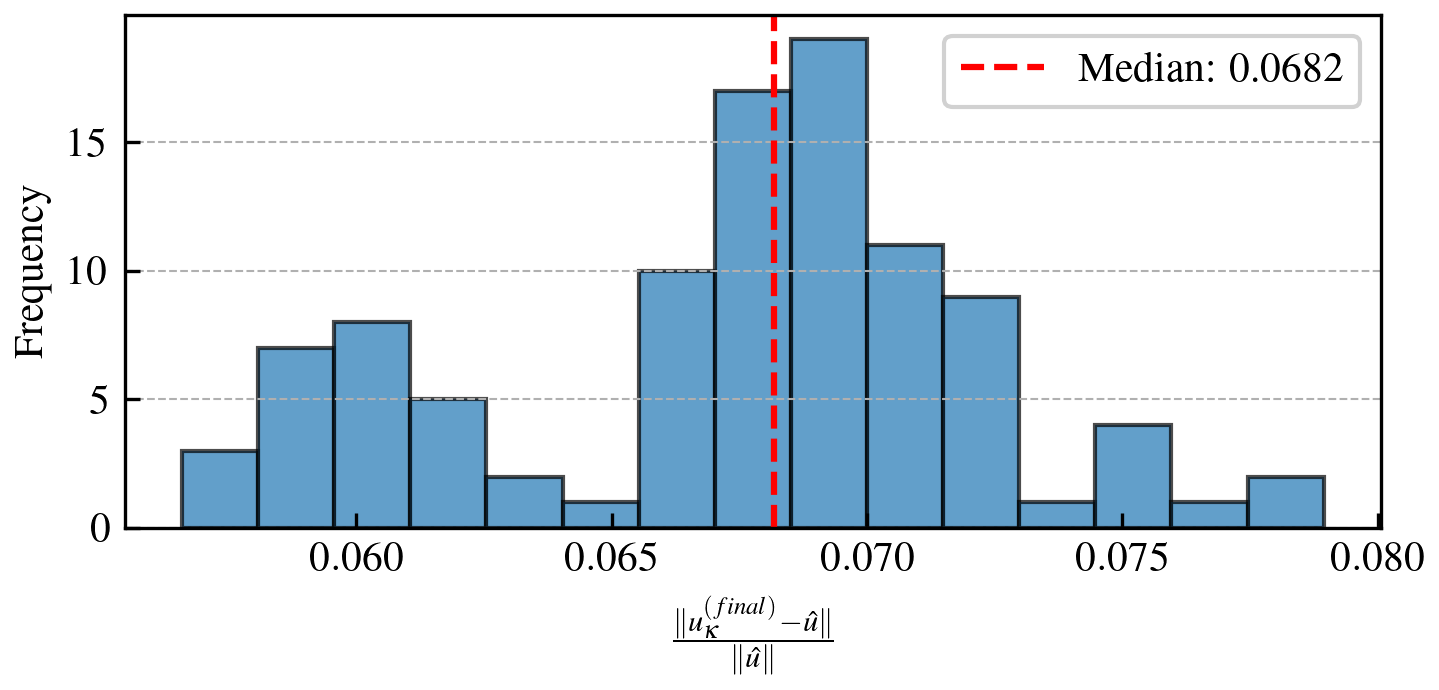

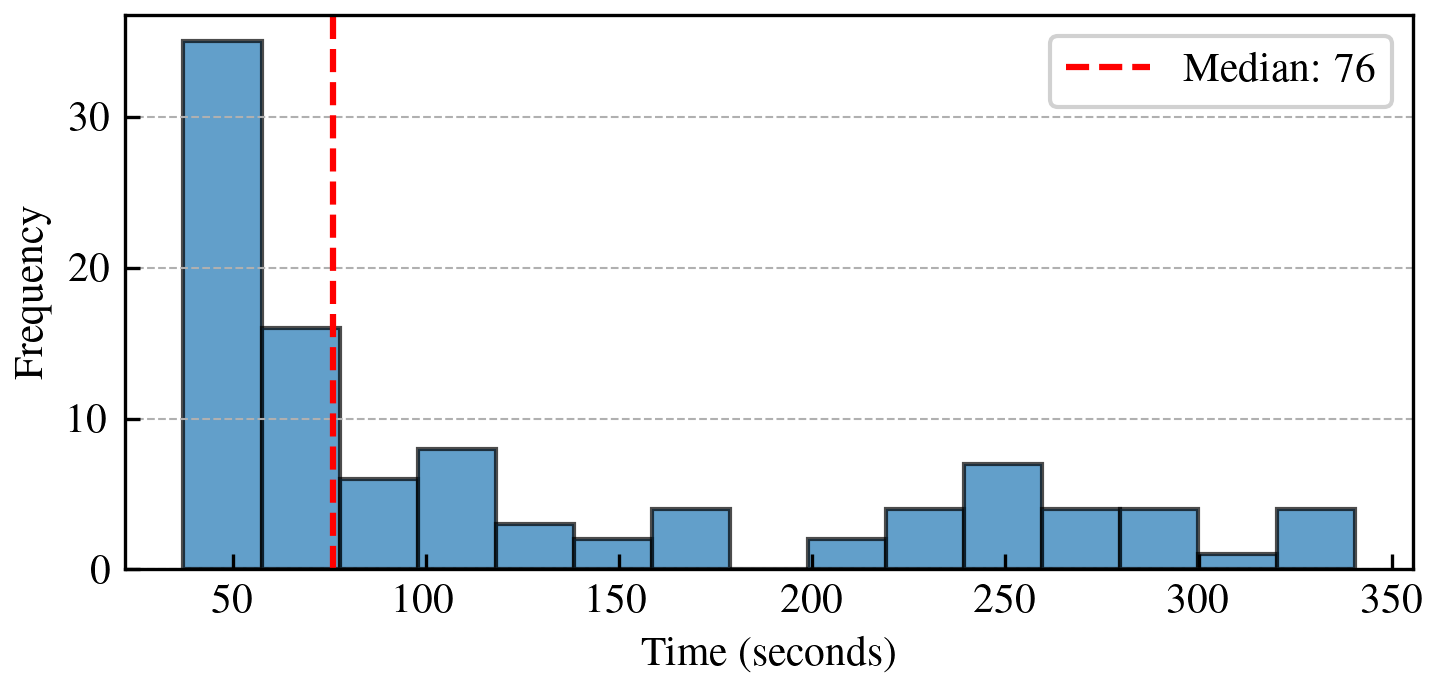

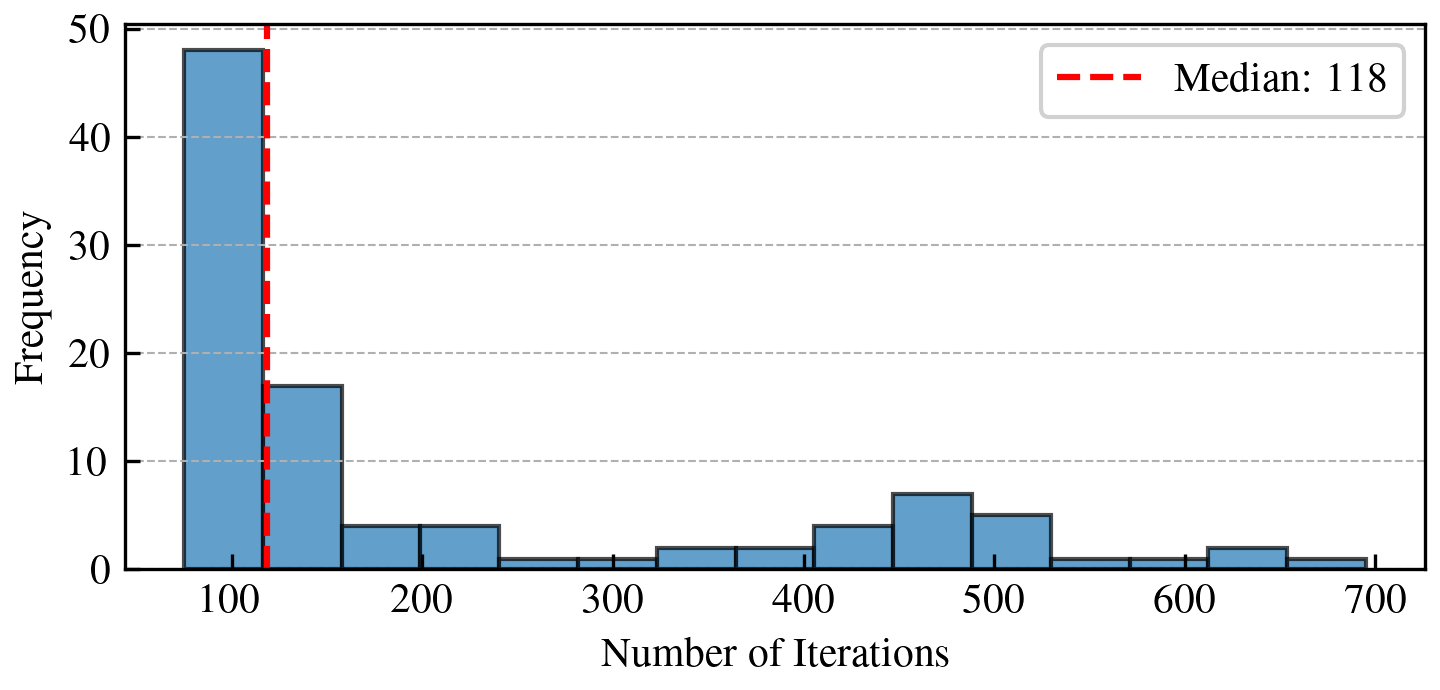

In [39]:
extracted_final = all_metrics_data['denoiser']

# --- Additional plots for final metric distributions ---
final_metric_configs = [
    {
        "metric": "kappa_final_rel_error",
        # "title": "Distribution of Final Parameter Error",
        "xlabel": r"$\frac{\|\kappa^{(final)} - \kappa\|}{\|\kappa\|}$",
        "filename": "../figures/final/denoiser-1e-5/final_kappa_error_dist.pdf",
        "figsize": (5, 2.5)
    },
    {
        "metric": "ukappa_recovered_rel_error",
        # "title": "Distribution of Final Solution Error (vs. True)",
        "xlabel": r"$\frac{\|u_{\kappa}^{(final)} - u\|}{\|u\|}$",
        "filename": "../figures/final/denoiser-1e-5/final_solution_error_true_dist.pdf",
        "figsize": (5, 2.5)
    },
    {
        "metric": "ukappa_recovered_rel_error_meas",
        # "title": "Distribution of Final Solution Error (vs. Measured)",
        "xlabel": r"$\frac{\|u_{\kappa}^{(final)} - \hat{u}\|}{\|\hat{u}\|}$",
        "filename": "../figures/final/denoiser-1e-5/final_solution_error_measured_dist.pdf",
        "figsize": (5, 2.5)
    },
    {
        "metric": "total_optimization_time",
        # "title": "Distribution of Total Optimization Time",
        "xlabel": "Time (seconds)",
        "filename": "../figures/final/denoiser-1e-5/optimization_time_dist.pdf",
        "figsize": (5, 2.5)
    },
    {
        "metric": "iterations",
        # "title": "Distribution of Iteration Counts",
        "xlabel": "Number of Iterations",
        "filename": "../figures/final/denoiser-1e-5/iteration_count_dist.pdf",
        "figsize": (5, 2.5)
    }
]

# Generate individual distribution plots
for config in final_metric_configs:
    metric = config["metric"]
    
    # Filter out NaNs
    data_list = [val for val in extracted_final[metric] if pd.notna(val)]
    if not data_list:
        print(f"No valid data for final metric: {metric}")
        continue
    
    # Create publication-quality figure
    fig, ax = plt.figure(figsize=config["figsize"]), plt.gca()
    
    # Plot histogram
    hist_bins = min(15, len(set(data_list)))  # Adjust bins based on unique values
    n, bins, patches = ax.hist(data_list, bins=hist_bins, edgecolor='black', 
                              alpha=0.7, color='#1f77b4')
    
    # Set labels
    ax.set_xlabel(config["xlabel"])
    ax.set_ylabel("Frequency")
    # ax.set_title(config["title"])
    
    # Add median line
    median_val = np.median(data_list)
    ax.axvline(median_val, color='red', linestyle='dashed', linewidth=1.5, 
              label=f'Median: {median_val:.3g}')
    
    # Use log scale if appropriate
    min_val, max_val = np.min(data_list), np.max(data_list)
    if 'error' in metric.lower() and min_val > 0 and max_val / min_val > 100:
        ax.set_xscale('log')
    
    # Add legend and grid
    ax.legend(loc='best', frameon=True, framealpha=0.9)
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
    
    # Make ticks inward
    ax.tick_params(direction='in', which='both')
    
    # # Add annotations
    # plt.figtext(0.01, 0.01, f'Based on {len(data_list)} valid runs', 
    #             fontsize=8, ha='left')
    
    plt.tight_layout()
    
    # Save figure (optional - comment out if not needed)
    # plt.savefig(config["filename"])
    
    plt.show()

In [15]:
all_metrics_data.keys()

dict_keys(['L2', 'tv', 'denoiser'])

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
import os
from pathlib import Path
import warnings

# --- Configuration ---
# Ensure current_lambda is defined and all_final_metrics is populated
# from the previous step
# Example: current_lambda = '1e-5'

current_lambda = '1e-5'
regularizer_names = ["L2", "tv", "denoiser"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green

# --- Define Final Metrics and Configurations ---
# Update filenames to reflect comparison
final_metric_configs = [
    {
        "metric": "kappa_final_rel_error",
        "xlabel": r"$\frac{\|\kappa^{(final)} - \kappa\|}{\|\kappa\|}$",
        "filename": f"../figures/final/comparison-{current_lambda}/final_kappa_error_dist_comp.pdf",
        "figsize": (5, 3) # Adjusted figsize slightly
    },
    {
        "metric": "ukappa_recovered_rel_error",
        "xlabel": r"$\frac{\|u_{\kappa}^{(final)} - u\|}{\|u\|}$",
        "filename": f"../figures/final/comparison-{current_lambda}/final_solution_error_true_dist_comp.pdf",
        "figsize": (5, 3)
    },
    {
        "metric": "ukappa_recovered_rel_error_meas",
        "xlabel": r"$\frac{\|u_{\kappa}^{(final)} - \hat{u}\|}{\|\hat{u}\|}$",
        "filename": f"../figures/final/comparison-{current_lambda}/final_solution_error_measured_dist_comp.pdf",
        "figsize": (5, 3)
    },
    {
        "metric": "total_optimization_time",
        "xlabel": "Time (seconds)",
        "filename": f"../figures/final/comparison-{current_lambda}/optimization_time_dist_comp.pdf",
        "figsize": (5, 3)
    },
    {
        "metric": "iterations",
        "xlabel": "Number of Iterations",
        "filename": f"../figures/final/comparison-{current_lambda}/iteration_count_dist_comp.pdf",
        "figsize": (5, 3)
    }
]

# --- Output directory for comparison plots ---
comparison_output_dir = Path(f"../figures/final/comparison-{current_lambda}")
os.makedirs(comparison_output_dir, exist_ok=True)


# --- Generate individual overlaid distribution plots ---
print(f"\n--- Generating Overlaid Distribution Plots for lambda = {current_lambda} ---")

for config in final_metric_configs:
    metric = config["metric"]
    print(f"  Plotting metric: {metric}")

    fig, ax = plt.figure(figsize=config["figsize"]), plt.gca()
    all_valid_data = []
    data_by_reg = {}
    medians = {}

    # --- Collect data and calculate overall range ---
    has_data = False
    for reg_name in regularizer_names:
        if reg_name in all_metrics_data:
            # Get data, filter NaNs
            data_list = [val for val in all_metrics_data[reg_name].get(metric, []) if pd.notna(val)]
            if data_list:
                 data_by_reg[reg_name] = data_list
                 all_valid_data.extend(data_list)
                 medians[reg_name] = np.median(data_list)
                 has_data = True
            else:
                 data_by_reg[reg_name] = [] # Store empty list if no valid data
                 medians[reg_name] = None
                 print(f"    No valid data for {metric} in {reg_name}.")
        else:
             print(f"    Regularizer {reg_name} not found in loaded data.")
             data_by_reg[reg_name] = []
             medians[reg_name] = None


    if not has_data:
        print(f"    Skipping {metric}: No valid data found across all regularizers.")
        plt.close(fig) # Close the empty figure
        continue

    # --- Determine common bins ---
    if not all_valid_data: # Should be redundant due to has_data check, but safe
         print(f"    Skipping {metric}: All_valid_data list is unexpectedly empty.")
         plt.close(fig)
         continue

    min_val_all = np.min(all_valid_data)
    max_val_all = np.max(all_valid_data)
    hist_bins_count = 15 # Number of bins
    # Adjust range slightly for robust binning
    bin_range = (min_val_all - 0.01 * abs(min_val_all), max_val_all + 0.01 * abs(max_val_all))
    # Handle case where min and max are the same
    if min_val_all == max_val_all:
        bin_range = (min_val_all - 0.5, max_val_all + 0.5)
        hist_bins_count = max(1, hist_bins_count // 3) # Fewer bins if only one value

    try:
        bins = np.linspace(bin_range[0], bin_range[1], hist_bins_count + 1)
    except ValueError as e:
        print(f"    Error creating bins for {metric} (range {bin_range}): {e}. Using auto bins.")
        bins = hist_bins_count # Fallback to auto-binning per histogram


    # --- Plot overlaid histograms ---
    for i, reg_name in enumerate(regularizer_names):
        if data_by_reg.get(reg_name): # Check if list is not empty
            print("Plotting histogram for ", reg_name)
            ax.hist(data_by_reg[reg_name], bins=bins, edgecolor='black',
                    alpha=0.6, color=colors[i], label=f'{reg_name}', density=False) # Use density=True if comparing shapes more than counts

    # --- Add Median Lines ---
    for i, reg_name in enumerate(regularizer_names):
         median_val = medians.get(reg_name)
         if median_val is not None:
             print("Plotting median line for ", reg_name)
             ax.axvline(median_val, color=colors[i], linestyle='dashed', linewidth=1.5,
                         label=f'Median ({reg_name}): {median_val:.3g}')


    # --- Set labels and styling ---
    ax.set_xlabel(config["xlabel"])
    ax.set_ylabel("Frequency")
    # ax.set_title(f"Distribution Comparison: {metric}") # Optional Title

    # Use log scale if appropriate (check across combined data)
    if 'error' in metric.lower() and min_val_all > 0:
         # Check if range spans orders of magnitude
         with warnings.catch_warnings(): # Suppress potential log(0) warning if min_val_all is tiny
             warnings.simplefilter("ignore", category=RuntimeWarning)
             if max_val_all / min_val_all > 100:
                 ax.set_xscale('log')

    # Add legend and grid
    ax.legend(loc='best', frameon=True, framealpha=0.9)
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

    # Make ticks inward
    ax.tick_params(direction='in', which='both')

    plt.tight_layout()

    # --- Save figure ---
    savepath = Path(config["filename"])
    # Ensure parent directory exists (it should from the setup)
    # os.makedirs(savepath.parent, exist_ok=True) # Redundant if dir created above
    try:
        plt.savefig(savepath)
        print(f"    Saved comparison plot: {savepath}")
    except Exception as e:
        print(f"    Error saving plot {savepath}: {e}")

    plt.close(fig) # Close figure after saving

print("\n--- Finished generating comparison distribution plots ---")



--- Generating Overlaid Distribution Plots for lambda = 1e-5 ---
  Plotting metric: kappa_final_rel_error
Plotting histogram for  L2
Plotting histogram for  tv
Plotting histogram for  denoiser
Plotting median line for  L2
Plotting median line for  tv
Plotting median line for  denoiser
    Saved comparison plot: ../figures/final/comparison-1e-5/final_kappa_error_dist_comp.pdf
  Plotting metric: ukappa_recovered_rel_error
Plotting histogram for  L2
Plotting histogram for  tv
Plotting histogram for  denoiser
Plotting median line for  L2
Plotting median line for  tv
Plotting median line for  denoiser
    Saved comparison plot: ../figures/final/comparison-1e-5/final_solution_error_true_dist_comp.pdf
  Plotting metric: ukappa_recovered_rel_error_meas
Plotting histogram for  L2
Plotting histogram for  tv
Plotting histogram for  denoiser
Plotting median line for  L2
Plotting median line for  tv
Plotting median line for  denoiser
    Saved comparison plot: ../figures/final/comparison-1e-5/fina

<>:200: SyntaxWarning: invalid escape sequence '\l'
<>:200: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3515288/2710102106.py:200: SyntaxWarning: invalid escape sequence '\l'
  label=f"Median $\lambda = {reg}$")


Found 100 runs with valid iteration counts. Max iterations: 448
Found 100 runs with valid iteration counts. Max iterations: 695
Found 100 runs with valid iteration counts. Max iterations: 683


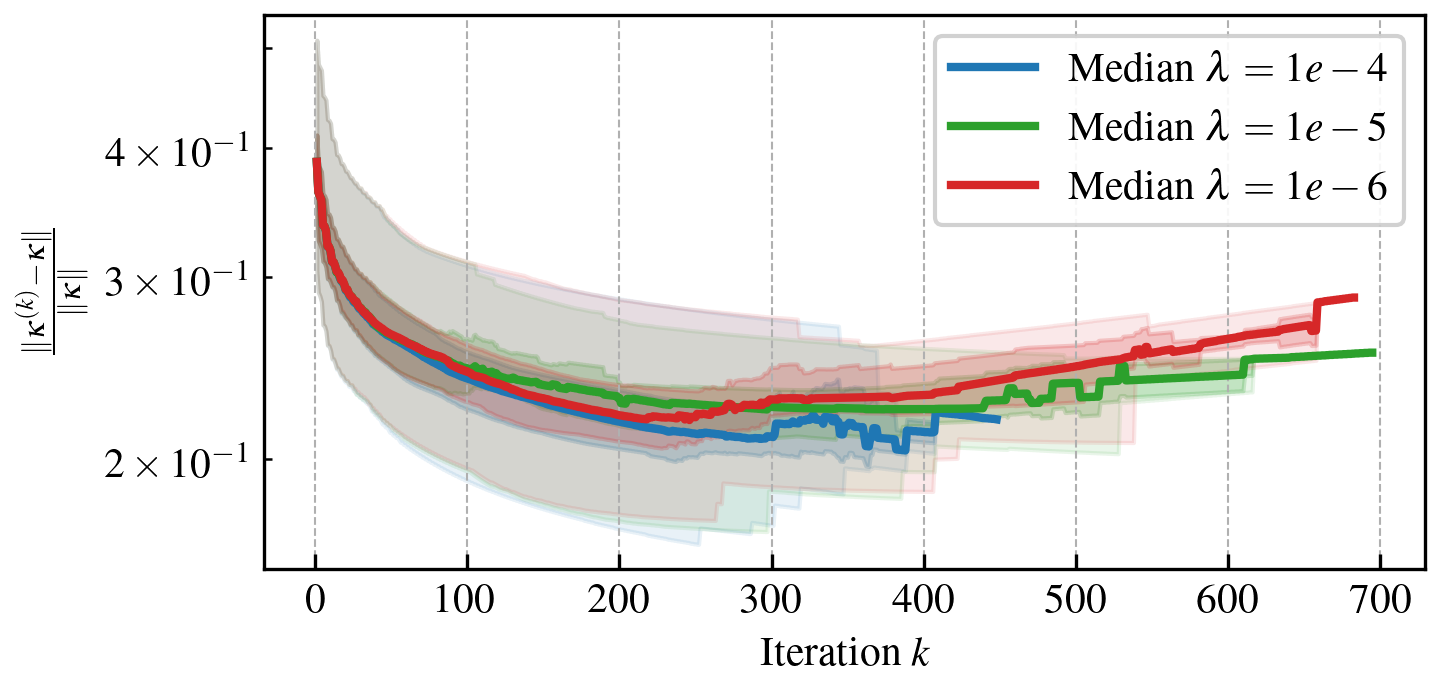

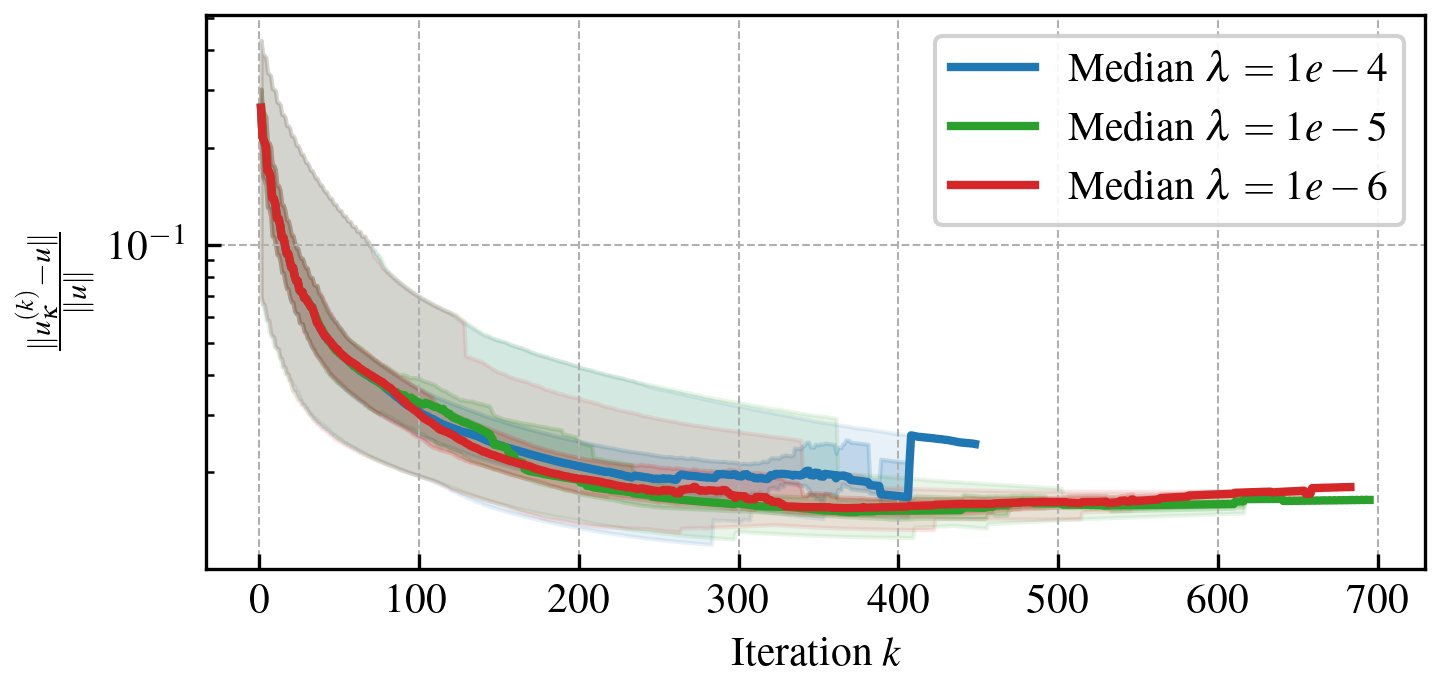

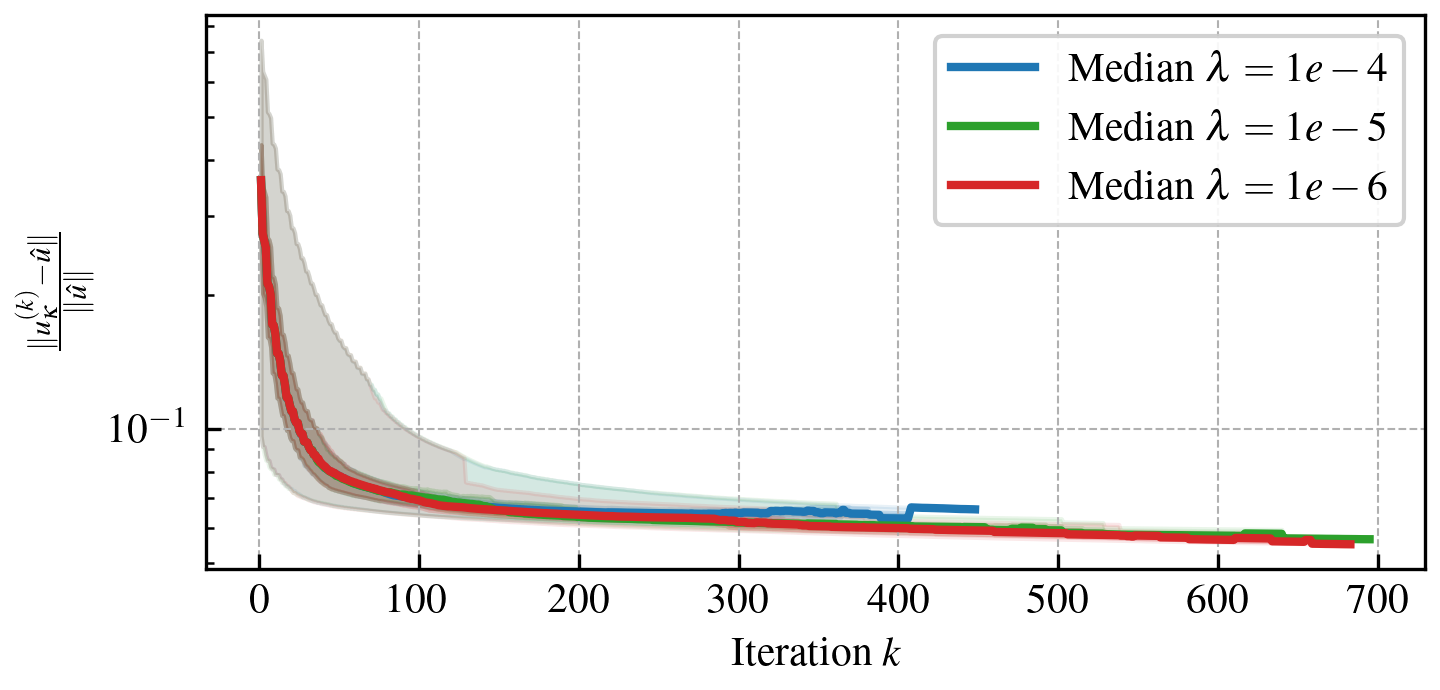

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os
from pathlib import Path

# Setup for publication quality
mpl.rcParams.update({
    # 'font.family': 'serif',
    'text.usetex': True,
    'figure.figsize': (5, 2.5),
    'figure.dpi': 300,
})

# Define the regularization strengths to compare
reg_strengths = ['1e-4', '1e-5', '1e-6']
colors = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red

# Load and process each result set
all_results = {}
for reg in reg_strengths:
    # Load each result file
    results_file = f"../results/analysis/results-denoiser-{reg}.npz"
    try:
        results = np.load(results_file, allow_pickle=True)
        # Process this result set using existing pipeline
        
        run_keys = list(results.keys())
        num_runs = len(run_keys)

        # --- 1. Data Extraction with Padding ---

        iterative_metrics = [
            "kappa_iterates_rel_errors",
            "ukappa_iterates_rel_errors",
            "ukappa_iterates_rel_errors_meas",
            "objectives",
            "reg_values", # Added reg_values 
        ]
        final_metrics = [
            "kappa_final_rel_error",
            "ukappa_recovered_rel_error",
            "ukappa_recovered_rel_error_meas",
            "total_optimization_time",
            "iterations",
        ]

        extracted_iterative = {metric: [] for metric in iterative_metrics}
        extracted_final = {metric: [] for metric in final_metrics}
        all_iteration_counts = []

        # First pass: Extract data and find max iterations
        max_iterations = 0
        for key in run_keys:
            try:
                # Use .item() to get the dictionary from the numpy scalar object
                run_data = results[key].item()
                if not isinstance(run_data, dict):
                    print(f"Warning: Item for key {key} is not a dict, skipping run.")
                    continue

                # Store actual iteration count for this run
                iterations_this_run = run_data.get("iterations")
                # Also check length of an iterative list as a fallback/consistency check
                iter_list_len = len(run_data.get("kappa_iterates_rel_errors", []))

                if iterations_this_run is None:
                    iterations_this_run = iter_list_len # Fallback if 'iterations' key missing
                    if iter_list_len == 0 and "objectives" in run_data: # Another fallback
                        iterations_this_run = len(run_data.get("objectives", []))

                if iterations_this_run is not None and iterations_this_run > 0:
                    all_iteration_counts.append(iterations_this_run)
                    max_iterations = max(max_iterations, iterations_this_run)
                else:
                    print(f"Warning: Could not determine iteration count for run {key}. Skipping.")
                    continue # Skip run if we can't determine iterations

                # Store iterative data for now (will pad later)
                for metric in iterative_metrics:
                    if metric in run_data:
                        extracted_iterative[metric].append(list(run_data[metric])) # Store as list for now
                    else:
                        # Placeholder indicating metric was missing for this run
                        extracted_iterative[metric].append(None)

                # Store final data
                for metric in final_metrics:
                    if metric in run_data:
                        extracted_final[metric].append(run_data[metric])
                    else:
                        extracted_final[metric].append(np.nan)

            except Exception as e:
                print(f"Error processing run {key}: {e}. Skipping run.")
                # Ensure lists in extracted_iterative maintain correspondence if skipping
                for metric in iterative_metrics:
                    # Check if we already added placeholder/data for this key in this loop iteration
                    if len(extracted_iterative.get(metric, [])) < len(all_iteration_counts) + (1 if 'iterations_this_run' in locals() and iterations_this_run is not None and iterations_this_run>0 else 0) :
                        extracted_iterative[metric].append(None) # Add placeholder if needed


        # Check if we found any valid runs
        if max_iterations == 0:
            print("Error: No valid runs found or max_iterations is zero. Cannot proceed with plotting.")
        else:
            print(f"Found {len(all_iteration_counts)} runs with valid iteration counts. Max iterations: {max_iterations}")
            iterations_axis = np.arange(1, max_iterations + 1)

            # Second pass: Pad iterative data and convert to numpy arrays
            padded_iterative_arrays = {}
            for metric in iterative_metrics:
                padded_data = []
                run_index = 0 # Keep track of which run we are processing
                for i, data_list in enumerate(extracted_iterative[metric]):
                    # Find corresponding iteration count for this run's data
                    # This assumes the order in extracted_iterative[metric] matches the order runs were successfully processed in the first loop
                    if data_list is not None: # Check if metric existed for this run
                        current_run_iterations = all_iteration_counts[run_index]
                        # Pad with NaNs if shorter than max_iterations
                        padding_needed = max_iterations - current_run_iterations
                        if padding_needed > 0:
                            padded_list = data_list + [np.nan] * padding_needed
                        else:
                            # Truncate if longer (shouldn't happen if max_iterations is correct, but safe)
                            padded_list = data_list[:max_iterations]

                        # Ensure final list has exactly max_iterations length
                        if len(padded_list) != max_iterations:
                            # This might happen if data_list was unexpectedly longer than 'iterations' reported
                            print(f"Warning: Length mismatch for metric '{metric}' in run {run_keys[i]}. Adjusting length.")
                            if len(padded_list) > max_iterations:
                                padded_list = padded_list[:max_iterations]
                            else: # Pad if still too short
                                padded_list = padded_list + [np.nan] * (max_iterations - len(padded_list))

                        padded_data.append(padded_list)
                        run_index += 1
                    else:
                        # If metric was missing for the run, add a list of NaNs
                        padded_data.append([np.nan] * max_iterations)
                        # We still need to increment run_index IF the run itself was valid (had iterations)
                        # Check if the overall index 'i' corresponds to a valid run index
                        if i < len(all_iteration_counts): # Safety check
                            run_index += 1


                if padded_data: # Only add if we collected some data
                    padded_iterative_arrays[metric] = np.array(padded_data, dtype=np.float64) # Use float64 for NaNs
        
        all_results[reg] = {
            'data': padded_iterative_arrays,
            'iterations_axis': iterations_axis,
            'num_runs': len(all_iteration_counts)
        }
    except Exception as e:
        print(f"Error loading {results_file}: {e}")

# Key metrics to compare across regularization strengths
comparison_metrics = [
    {
        "metric": "kappa_iterates_rel_errors",
        "ylabel": r"$\frac{\|\kappa^{(k)} - \kappa\|}{\|\kappa\|}$",
        "filename": "../figures/comparison/kappa_error_comparison.pdf"
    },
    {
        "metric": "ukappa_iterates_rel_errors",
        "ylabel": r"$\frac{\|u_{\kappa}^{(k)} - u\|}{\|u\|}$",
        "filename": "../figures/comparison/solution_error_true_comparison.pdf"
    },
    {
        "metric": "ukappa_iterates_rel_errors_meas",
        "ylabel": r"$\frac{\|u_{\kappa}^{(k)} - \hat{u}\|}{\|\hat{u}\|}$",
        "filename": "../figures/comparison/solution_error_measured_comparison.pdf"
    }
]

# Create comparison plots
for config in comparison_metrics:
    metric = config["metric"]
    
    fig, ax = plt.figure(), plt.gca()
    
    # Plot each regularization strength
    for i, reg in enumerate(reg_strengths):
        if reg not in all_results or metric not in all_results[reg]['data']:
            print(f"Skipping {reg} for {metric}: Not found in data")
            continue
            
        result = all_results[reg]
        data_array = result['data'][metric]
        valid_mask = ~np.all(np.isnan(data_array), axis=0)
        iterations = result['iterations_axis'][valid_mask]
        
        # Calculate median values
        median_vals = np.nanmedian(data_array[:, valid_mask], axis=0)
        
        # Plot median line 
        ax.plot(iterations, median_vals, '-', color=colors[i], linewidth=2,
                label=f"Median $\lambda = {reg}$")
        
        # Plot quartiles
        q1_vals = np.nanpercentile(data_array[:, valid_mask], 25, axis=0)
        q3_vals = np.nanpercentile(data_array[:, valid_mask], 75, axis=0)
        ax.fill_between(iterations, q1_vals, q3_vals, color=colors[i], alpha=0.2,)
        # Plot min-max range
        min_vals = np.nanmin(data_array[:, valid_mask], axis=0)
        max_vals = np.nanmax(data_array[:, valid_mask], axis=0)
        ax.fill_between(iterations, min_vals, max_vals, color=colors[i], alpha=0.1)
    
    # Set labels and styling
    ax.set_xlabel('Iteration $k$')
    ax.set_ylabel(config["ylabel"])
    if 'error' in metric.lower():
        ax.set_yscale('log')
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend(loc='best', framealpha=0.9)
    ax.tick_params(direction='in', which='both')
    
    plt.tight_layout()
    
    # Save figure
    savepath = Path(config["filename"])
    if not savepath.parent.exists():
        os.makedirs(savepath.parent, exist_ok=True)
    plt.savefig(savepath)
    
    plt.show()

In [49]:
# get the measurement and the true solution for keys 737, 521, 761
#     "kappa_true": true_kappa, # true kappa
#     "kappa_recovered": kappa_recovered, # recovered kappa
#     "kappa_final_rel_error": kappa_final_rel_l2_error, # relative L2 error in kappa
#     "ukappa_true": ukappa, # true solution
#     "ukappa_measured": u_meas, # measured solution
#     "ukappa_recovered": u_recovered, # recovered solution
keys = [737, 521, 761]
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import math
import os
from pathlib import Path

# define results
lambda_list = ['1e-4', '1e-5', '1e-6']
current_lambda = lambda_list[1]
results = np.load(f"../results/analysis/results-denoiser-{current_lambda}.npz", allow_pickle=True)

# --- Keys to visualize ---
keys_to_plot = ['737', '521', '761', '820', '76'] # Add or remove keys as needed

# --- Output directory ---
output_dir = Path(f"../figures/individual_runs/denoiser-{current_lambda}")
os.makedirs(output_dir, exist_ok=True)

# --- Helper function to reshape and determine grid ---
def get_field_data(data_array):
    """Reshapes flattened array and creates a meshgrid."""
    if data_array is None or not isinstance(data_array, np.ndarray) or data_array.ndim != 1:
         print(f"Warning: Invalid data array provided. Shape: {data_array.shape if data_array is not None else 'None'}")
         return None, None, None # Return None if data is invalid

    size = data_array.shape[0]
    dim = int(math.sqrt(size))
    if dim * dim != size:
        print(f"Warning: Array size {size} is not a perfect square. Cannot reshape to 2D. Skipping field plot.")
        return None, None, None # Return None if not reshapeable

    field = data_array.reshape((dim, dim))
    x = np.linspace(0, 1, dim)
    y = np.linspace(0, 1, dim)
    X, Y = np.meshgrid(x, y)
    return field, X, Y

# --- Loop through specified keys ---
for key in keys_to_plot:
    if key not in results:
        print(f"Warning: Key '{key}' not found in results. Skipping.")
        continue

    try:
        run_data = results[key].item()
        if not isinstance(run_data, dict):
            print(f"Warning: Data for key '{key}' is not a dictionary. Skipping.")
            continue

        # --- Plot Kappa Fields with Error Map ---
        kappa_true_data = run_data.get("kappa_true")
        kappa_rec_data = run_data.get("kappa_recovered")

        kappa_true, Kx, Ky = get_field_data(kappa_true_data)
        kappa_rec, _, _ = get_field_data(kappa_rec_data) # Grid is the same

        if kappa_true is not None and kappa_rec is not None:
            # Calculate error map
            kappa_error = kappa_rec - kappa_true
            error_max_abs_k = np.max(np.abs(kappa_error)) # For symmetric colormap

            # Create 1x3 subplot figure
            fig_kappa, axes_kappa = plt.subplots(1, 3, figsize=(5, 1.8)) # Adjusted size for 3 plots
            # fig_kappa.suptitle(f'Run: {key}', fontsize=14) # Optional overall title

            # Determine shared color limits for true/recovered
            vmin_k = min(np.min(kappa_true), np.min(kappa_rec))
            vmax_k = max(np.max(kappa_true), np.max(kappa_rec))

            # Plot True Kappa
            im1 = axes_kappa[0].imshow(kappa_true, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_k, vmax=vmax_k)
            # axes_kappa[0].set_title(r'True $\kappa$') # Removed title
            axes_kappa[0].set_xlabel('$x_1$')
            axes_kappa[0].set_ylabel('$x_2$')
            axes_kappa[0].set_aspect('equal', 'box')
            fig_kappa.colorbar(im1, ax=axes_kappa[0], fraction=0.046, pad=0.04)

            # Plot Recovered Kappa
            im2 = axes_kappa[1].imshow(kappa_rec, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_k, vmax=vmax_k)
            # axes_kappa[1].set_title(r'Recovered $\kappa^{(final)}$') # Removed title
            axes_kappa[1].set_xlabel('$x_1$')
            axes_kappa[1].set_ylabel('$x_2$')
            axes_kappa[1].set_aspect('equal', 'box')
            fig_kappa.colorbar(im2, ax=axes_kappa[1], fraction=0.046, pad=0.04)

            # Plot Error Kappa
            im_err_k = axes_kappa[2].imshow(kappa_error, extent=[0, 1, 0, 1], origin='lower', cmap='coolwarm', vmin=-error_max_abs_k, vmax=error_max_abs_k)
            # axes_kappa[2].set_title(r'Error $\kappa^{(final)} - \kappa$') # Removed title
            axes_kappa[2].set_xlabel('$x_1$')
            axes_kappa[2].set_ylabel('$x_2$')
            axes_kappa[2].set_aspect('equal', 'box')
            fig_kappa.colorbar(im_err_k, ax=axes_kappa[2], fraction=0.046, pad=0.04)


            plt.tight_layout(rect=[0, 0.03, 1, 1.0]) # Adjust layout
            kappa_filename = output_dir / f"kappa_comparison_run_{key}.pdf"
            plt.savefig(kappa_filename)
            print(f"Saved Kappa plot: {kappa_filename}")
            plt.close(fig_kappa) # Close figure to avoid displaying inline if not needed
            plt.show() # Uncomment if you want to see plots inline

        else:
             print(f"Skipping Kappa plots for run {key} due to data issues.")


        # --- Plot Solution Fields with Error Map ---
        u_true_data = run_data.get("ukappa_true")
        u_meas_data = run_data.get("ukappa_measured")
        u_rec_data = run_data.get("ukappa_recovered")

        u_true, Ux, Uy = get_field_data(u_true_data)
        u_meas, _, _ = get_field_data(u_meas_data)
        u_rec, _, _ = get_field_data(u_rec_data)

        if u_true is not None and u_meas is not None and u_rec is not None:
            # Calculate error map
            u_error = u_rec - u_true
            error_max_abs_u = np.max(np.abs(u_error)) # For symmetric colormap

            # Create 1x4 subplot figure
            fig_u, axes_u = plt.subplots(1, 4, figsize=(6.5, 1.8)) # Adjusted size for 4 plots
            # fig_u.suptitle(f'Run: {key}', fontsize=16) # Optional overall title

            # Determine shared color limits for true/measured/recovered
            vmin_u = min(np.min(u_true), np.min(u_meas), np.min(u_rec))
            vmax_u = max(np.max(u_true), np.max(u_meas), np.max(u_rec))

            # Plot True Solution
            im3 = axes_u[0].imshow(u_true, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_u, vmax=vmax_u)
            # axes_u[0].set_title(r'$u$') # Removed title
            axes_u[0].set_xlabel('$x_1$')
            axes_u[0].set_ylabel('$x_2$')
            axes_u[0].set_aspect('equal', 'box')
            fig_u.colorbar(im3, ax=axes_u[0], fraction=0.046, pad=0.04)

            # Plot Measured Solution
            im4 = axes_u[1].imshow(u_meas, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_u, vmax=vmax_u)
            # axes_u[1].set_title(r'$\hat{u}$') # Removed title
            axes_u[1].set_xlabel('$x_1$')
            axes_u[1].set_ylabel('$x_2$')
            axes_u[1].set_aspect('equal', 'box')
            fig_u.colorbar(im4, ax=axes_u[1], fraction=0.046, pad=0.04)

            # Plot Recovered Solution
            im5 = axes_u[2].imshow(u_rec, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_u, vmax=vmax_u)
            # axes_u[2].set_title(r'$u_{\kappa}^{(final)}$') # Removed title
            axes_u[2].set_xlabel('$x_1$')
            axes_u[2].set_ylabel('$x_2$')
            axes_u[2].set_aspect('equal', 'box')
            fig_u.colorbar(im5, ax=axes_u[2], fraction=0.046, pad=0.04)

            # Plot Error Solution
            im_err_u = axes_u[3].imshow(u_error, extent=[0, 1, 0, 1], origin='lower', cmap='coolwarm', vmin=-error_max_abs_u, vmax=error_max_abs_u)
            # axes_u[3].set_title(r'$u_{\kappa}^{(final)} - u$') # Removed title
            axes_u[3].set_xlabel('$x_1$')
            axes_u[3].set_ylabel('$x_2$')
            axes_u[3].set_aspect('equal', 'box')
            fig_u.colorbar(im_err_u, ax=axes_u[3], fraction=0.046, pad=0.04)


            plt.tight_layout(rect=[0, 0.03, 1, 1.0]) # Adjust layout
            u_filename = output_dir / f"solution_comparison_run_{key}.pdf"
            plt.savefig(u_filename)
            print(f"Saved Solution plot: {u_filename}")
            plt.close(fig_u) # Close figure
            plt.show() # Uncomment if you want to see plots inline

        else:
             print(f"Skipping Solution plots for run {key} due to data issues.")

    except Exception as e:
        print(f"Error processing key '{key}': {e}")


Saved Kappa plot: ../figures/individual_runs/denoiser-1e-5/kappa_comparison_run_737.pdf
Saved Solution plot: ../figures/individual_runs/denoiser-1e-5/solution_comparison_run_737.pdf
Saved Kappa plot: ../figures/individual_runs/denoiser-1e-5/kappa_comparison_run_521.pdf
Saved Solution plot: ../figures/individual_runs/denoiser-1e-5/solution_comparison_run_521.pdf
Saved Kappa plot: ../figures/individual_runs/denoiser-1e-5/kappa_comparison_run_761.pdf
Saved Solution plot: ../figures/individual_runs/denoiser-1e-5/solution_comparison_run_761.pdf
Saved Kappa plot: ../figures/individual_runs/denoiser-1e-5/kappa_comparison_run_820.pdf
Saved Solution plot: ../figures/individual_runs/denoiser-1e-5/solution_comparison_run_820.pdf
Saved Kappa plot: ../figures/individual_runs/denoiser-1e-5/kappa_comparison_run_76.pdf
Saved Solution plot: ../figures/individual_runs/denoiser-1e-5/solution_comparison_run_76.pdf


In [50]:
# get the measurement and the true solution for keys 737, 521, 761
#     "kappa_true": true_kappa, # true kappa
#     "kappa_recovered": kappa_recovered, # recovered kappa
#     "kappa_final_rel_error": kappa_final_rel_l2_error, # relative L2 error in kappa
#     "ukappa_true": ukappa, # true solution
#     "ukappa_measured": u_meas, # measured solution
#     "ukappa_recovered": u_recovered, # recovered solution
keys = [737, 521, 761]
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import math
import os
from pathlib import Path

# define results
lambda_list = ['1e-4', '1e-5', '1e-6']
current_lambda = lambda_list[1]
results = np.load(f"../results/analysis/results-tv-{current_lambda}.npz", allow_pickle=True)

# --- Keys to visualize ---
keys_to_plot = ['737', '521', '761', '820', '76'] # Add or remove keys as needed

# --- Output directory ---
output_dir = Path(f"../figures/individual_runs/tv-{current_lambda}")
os.makedirs(output_dir, exist_ok=True)

# --- Helper function to reshape and determine grid ---
def get_field_data(data_array):
    """Reshapes flattened array and creates a meshgrid."""
    if data_array is None or not isinstance(data_array, np.ndarray) or data_array.ndim != 1:
         print(f"Warning: Invalid data array provided. Shape: {data_array.shape if data_array is not None else 'None'}")
         return None, None, None # Return None if data is invalid

    size = data_array.shape[0]
    dim = int(math.sqrt(size))
    if dim * dim != size:
        print(f"Warning: Array size {size} is not a perfect square. Cannot reshape to 2D. Skipping field plot.")
        return None, None, None # Return None if not reshapeable

    field = data_array.reshape((dim, dim))
    x = np.linspace(0, 1, dim)
    y = np.linspace(0, 1, dim)
    X, Y = np.meshgrid(x, y)
    return field, X, Y

# --- Loop through specified keys ---
for key in keys_to_plot:
    if key not in results:
        print(f"Warning: Key '{key}' not found in results. Skipping.")
        continue

    try:
        run_data = results[key].item()
        if not isinstance(run_data, dict):
            print(f"Warning: Data for key '{key}' is not a dictionary. Skipping.")
            continue

        # --- Plot Kappa Fields with Error Map ---
        kappa_true_data = run_data.get("kappa_true")
        kappa_rec_data = run_data.get("kappa_recovered")

        kappa_true, Kx, Ky = get_field_data(kappa_true_data)
        kappa_rec, _, _ = get_field_data(kappa_rec_data) # Grid is the same

        if kappa_true is not None and kappa_rec is not None:
            # Calculate error map
            kappa_error = kappa_rec - kappa_true
            error_max_abs_k = np.max(np.abs(kappa_error)) # For symmetric colormap

            # Create 1x3 subplot figure
            fig_kappa, axes_kappa = plt.subplots(1, 3, figsize=(5, 1.8)) # Adjusted size for 3 plots
            # fig_kappa.suptitle(f'Run: {key}', fontsize=14) # Optional overall title

            # Determine shared color limits for true/recovered
            vmin_k = min(np.min(kappa_true), np.min(kappa_rec))
            vmax_k = max(np.max(kappa_true), np.max(kappa_rec))

            # Plot True Kappa
            im1 = axes_kappa[0].imshow(kappa_true, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_k, vmax=vmax_k)
            # axes_kappa[0].set_title(r'True $\kappa$') # Removed title
            axes_kappa[0].set_xlabel('$x_1$')
            axes_kappa[0].set_ylabel('$x_2$')
            axes_kappa[0].set_aspect('equal', 'box')
            fig_kappa.colorbar(im1, ax=axes_kappa[0], fraction=0.046, pad=0.04)

            # Plot Recovered Kappa
            im2 = axes_kappa[1].imshow(kappa_rec, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_k, vmax=vmax_k)
            # axes_kappa[1].set_title(r'Recovered $\kappa^{(final)}$') # Removed title
            axes_kappa[1].set_xlabel('$x_1$')
            axes_kappa[1].set_ylabel('$x_2$')
            axes_kappa[1].set_aspect('equal', 'box')
            fig_kappa.colorbar(im2, ax=axes_kappa[1], fraction=0.046, pad=0.04)

            # Plot Error Kappa
            im_err_k = axes_kappa[2].imshow(kappa_error, extent=[0, 1, 0, 1], origin='lower', cmap='coolwarm', vmin=-error_max_abs_k, vmax=error_max_abs_k)
            # axes_kappa[2].set_title(r'Error $\kappa^{(final)} - \kappa$') # Removed title
            axes_kappa[2].set_xlabel('$x_1$')
            axes_kappa[2].set_ylabel('$x_2$')
            axes_kappa[2].set_aspect('equal', 'box')
            fig_kappa.colorbar(im_err_k, ax=axes_kappa[2], fraction=0.046, pad=0.04)


            plt.tight_layout(rect=[0, 0.03, 1, 1.0]) # Adjust layout
            kappa_filename = output_dir / f"kappa_comparison_run_{key}.pdf"
            plt.savefig(kappa_filename)
            print(f"Saved Kappa plot: {kappa_filename}")
            plt.close(fig_kappa) # Close figure to avoid displaying inline if not needed
            plt.show() # Uncomment if you want to see plots inline

        else:
             print(f"Skipping Kappa plots for run {key} due to data issues.")


        # --- Plot Solution Fields with Error Map ---
        u_true_data = run_data.get("ukappa_true")
        u_meas_data = run_data.get("ukappa_measured")
        u_rec_data = run_data.get("ukappa_recovered")

        u_true, Ux, Uy = get_field_data(u_true_data)
        u_meas, _, _ = get_field_data(u_meas_data)
        u_rec, _, _ = get_field_data(u_rec_data)

        if u_true is not None and u_meas is not None and u_rec is not None:
            # Calculate error map
            u_error = u_rec - u_true
            error_max_abs_u = np.max(np.abs(u_error)) # For symmetric colormap

            # Create 1x4 subplot figure
            fig_u, axes_u = plt.subplots(1, 4, figsize=(6.5, 1.8)) # Adjusted size for 4 plots
            # fig_u.suptitle(f'Run: {key}', fontsize=16) # Optional overall title

            # Determine shared color limits for true/measured/recovered
            vmin_u = min(np.min(u_true), np.min(u_meas), np.min(u_rec))
            vmax_u = max(np.max(u_true), np.max(u_meas), np.max(u_rec))

            # Plot True Solution
            im3 = axes_u[0].imshow(u_true, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_u, vmax=vmax_u)
            # axes_u[0].set_title(r'$u$') # Removed title
            axes_u[0].set_xlabel('$x_1$')
            axes_u[0].set_ylabel('$x_2$')
            axes_u[0].set_aspect('equal', 'box')
            fig_u.colorbar(im3, ax=axes_u[0], fraction=0.046, pad=0.04)

            # Plot Measured Solution
            im4 = axes_u[1].imshow(u_meas, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_u, vmax=vmax_u)
            # axes_u[1].set_title(r'$\hat{u}$') # Removed title
            axes_u[1].set_xlabel('$x_1$')
            axes_u[1].set_ylabel('$x_2$')
            axes_u[1].set_aspect('equal', 'box')
            fig_u.colorbar(im4, ax=axes_u[1], fraction=0.046, pad=0.04)

            # Plot Recovered Solution
            im5 = axes_u[2].imshow(u_rec, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_u, vmax=vmax_u)
            # axes_u[2].set_title(r'$u_{\kappa}^{(final)}$') # Removed title
            axes_u[2].set_xlabel('$x_1$')
            axes_u[2].set_ylabel('$x_2$')
            axes_u[2].set_aspect('equal', 'box')
            fig_u.colorbar(im5, ax=axes_u[2], fraction=0.046, pad=0.04)

            # Plot Error Solution
            im_err_u = axes_u[3].imshow(u_error, extent=[0, 1, 0, 1], origin='lower', cmap='coolwarm', vmin=-error_max_abs_u, vmax=error_max_abs_u)
            # axes_u[3].set_title(r'$u_{\kappa}^{(final)} - u$') # Removed title
            axes_u[3].set_xlabel('$x_1$')
            axes_u[3].set_ylabel('$x_2$')
            axes_u[3].set_aspect('equal', 'box')
            fig_u.colorbar(im_err_u, ax=axes_u[3], fraction=0.046, pad=0.04)


            plt.tight_layout(rect=[0, 0.03, 1, 1.0]) # Adjust layout
            u_filename = output_dir / f"solution_comparison_run_{key}.pdf"
            plt.savefig(u_filename)
            print(f"Saved Solution plot: {u_filename}")
            plt.close(fig_u) # Close figure
            plt.show() # Uncomment if you want to see plots inline

        else:
             print(f"Skipping Solution plots for run {key} due to data issues.")

    except Exception as e:
        print(f"Error processing key '{key}': {e}")


Saved Kappa plot: ../figures/individual_runs/tv-1e-5/kappa_comparison_run_737.pdf
Saved Solution plot: ../figures/individual_runs/tv-1e-5/solution_comparison_run_737.pdf
Saved Kappa plot: ../figures/individual_runs/tv-1e-5/kappa_comparison_run_521.pdf
Saved Solution plot: ../figures/individual_runs/tv-1e-5/solution_comparison_run_521.pdf
Saved Kappa plot: ../figures/individual_runs/tv-1e-5/kappa_comparison_run_761.pdf
Saved Solution plot: ../figures/individual_runs/tv-1e-5/solution_comparison_run_761.pdf
Saved Kappa plot: ../figures/individual_runs/tv-1e-5/kappa_comparison_run_820.pdf
Saved Solution plot: ../figures/individual_runs/tv-1e-5/solution_comparison_run_820.pdf
Saved Kappa plot: ../figures/individual_runs/tv-1e-5/kappa_comparison_run_76.pdf
Saved Solution plot: ../figures/individual_runs/tv-1e-5/solution_comparison_run_76.pdf


In [51]:
# get the measurement and the true solution for keys 737, 521, 761
#     "kappa_true": true_kappa, # true kappa
#     "kappa_recovered": kappa_recovered, # recovered kappa
#     "kappa_final_rel_error": kappa_final_rel_l2_error, # relative L2 error in kappa
#     "ukappa_true": ukappa, # true solution
#     "ukappa_measured": u_meas, # measured solution
#     "ukappa_recovered": u_recovered, # recovered solution
keys = [737, 521, 761]
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import math
import os
from pathlib import Path

# define results
lambda_list = ['1e-4', '1e-5', '1e-6']
current_lambda = lambda_list[1]
results = np.load(f"../results/analysis/results-L2-{current_lambda}.npz", allow_pickle=True)

# --- Keys to visualize ---
keys_to_plot = ['737', '521', '761', '820', '76'] # Add or remove keys as needed

# --- Output directory ---
output_dir = Path(f"../figures/individual_runs/L2-{current_lambda}")
os.makedirs(output_dir, exist_ok=True)

# --- Helper function to reshape and determine grid ---
def get_field_data(data_array):
    """Reshapes flattened array and creates a meshgrid."""
    if data_array is None or not isinstance(data_array, np.ndarray) or data_array.ndim != 1:
         print(f"Warning: Invalid data array provided. Shape: {data_array.shape if data_array is not None else 'None'}")
         return None, None, None # Return None if data is invalid

    size = data_array.shape[0]
    dim = int(math.sqrt(size))
    if dim * dim != size:
        print(f"Warning: Array size {size} is not a perfect square. Cannot reshape to 2D. Skipping field plot.")
        return None, None, None # Return None if not reshapeable

    field = data_array.reshape((dim, dim))
    x = np.linspace(0, 1, dim)
    y = np.linspace(0, 1, dim)
    X, Y = np.meshgrid(x, y)
    return field, X, Y

# --- Loop through specified keys ---
for key in keys_to_plot:
    if key not in results:
        print(f"Warning: Key '{key}' not found in results. Skipping.")
        continue

    try:
        run_data = results[key].item()
        if not isinstance(run_data, dict):
            print(f"Warning: Data for key '{key}' is not a dictionary. Skipping.")
            continue

        # --- Plot Kappa Fields with Error Map ---
        kappa_true_data = run_data.get("kappa_true")
        kappa_rec_data = run_data.get("kappa_recovered")

        kappa_true, Kx, Ky = get_field_data(kappa_true_data)
        kappa_rec, _, _ = get_field_data(kappa_rec_data) # Grid is the same

        if kappa_true is not None and kappa_rec is not None:
            # Calculate error map
            kappa_error = kappa_rec - kappa_true
            error_max_abs_k = np.max(np.abs(kappa_error)) # For symmetric colormap

            # Create 1x3 subplot figure
            fig_kappa, axes_kappa = plt.subplots(1, 3, figsize=(5, 1.8)) # Adjusted size for 3 plots
            # fig_kappa.suptitle(f'Run: {key}', fontsize=14) # Optional overall title

            # Determine shared color limits for true/recovered
            vmin_k = min(np.min(kappa_true), np.min(kappa_rec))
            vmax_k = max(np.max(kappa_true), np.max(kappa_rec))

            # Plot True Kappa
            im1 = axes_kappa[0].imshow(kappa_true, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_k, vmax=vmax_k)
            # axes_kappa[0].set_title(r'True $\kappa$') # Removed title
            axes_kappa[0].set_xlabel('$x_1$')
            axes_kappa[0].set_ylabel('$x_2$')
            axes_kappa[0].set_aspect('equal', 'box')
            fig_kappa.colorbar(im1, ax=axes_kappa[0], fraction=0.046, pad=0.04)

            # Plot Recovered Kappa
            im2 = axes_kappa[1].imshow(kappa_rec, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_k, vmax=vmax_k)
            # axes_kappa[1].set_title(r'Recovered $\kappa^{(final)}$') # Removed title
            axes_kappa[1].set_xlabel('$x_1$')
            axes_kappa[1].set_ylabel('$x_2$')
            axes_kappa[1].set_aspect('equal', 'box')
            fig_kappa.colorbar(im2, ax=axes_kappa[1], fraction=0.046, pad=0.04)

            # Plot Error Kappa
            im_err_k = axes_kappa[2].imshow(kappa_error, extent=[0, 1, 0, 1], origin='lower', cmap='coolwarm', vmin=-error_max_abs_k, vmax=error_max_abs_k)
            # axes_kappa[2].set_title(r'Error $\kappa^{(final)} - \kappa$') # Removed title
            axes_kappa[2].set_xlabel('$x_1$')
            axes_kappa[2].set_ylabel('$x_2$')
            axes_kappa[2].set_aspect('equal', 'box')
            fig_kappa.colorbar(im_err_k, ax=axes_kappa[2], fraction=0.046, pad=0.04)


            plt.tight_layout(rect=[0, 0.03, 1, 1.0]) # Adjust layout
            kappa_filename = output_dir / f"kappa_comparison_run_{key}.pdf"
            plt.savefig(kappa_filename)
            print(f"Saved Kappa plot: {kappa_filename}")
            plt.close(fig_kappa) # Close figure to avoid displaying inline if not needed
            plt.show() # Uncomment if you want to see plots inline

        else:
             print(f"Skipping Kappa plots for run {key} due to data issues.")


        # --- Plot Solution Fields with Error Map ---
        u_true_data = run_data.get("ukappa_true")
        u_meas_data = run_data.get("ukappa_measured")
        u_rec_data = run_data.get("ukappa_recovered")

        u_true, Ux, Uy = get_field_data(u_true_data)
        u_meas, _, _ = get_field_data(u_meas_data)
        u_rec, _, _ = get_field_data(u_rec_data)

        if u_true is not None and u_meas is not None and u_rec is not None:
            # Calculate error map
            u_error = u_rec - u_true
            error_max_abs_u = np.max(np.abs(u_error)) # For symmetric colormap

            # Create 1x4 subplot figure
            fig_u, axes_u = plt.subplots(1, 4, figsize=(6.5, 1.8)) # Adjusted size for 4 plots
            # fig_u.suptitle(f'Run: {key}', fontsize=16) # Optional overall title

            # Determine shared color limits for true/measured/recovered
            vmin_u = min(np.min(u_true), np.min(u_meas), np.min(u_rec))
            vmax_u = max(np.max(u_true), np.max(u_meas), np.max(u_rec))

            # Plot True Solution
            im3 = axes_u[0].imshow(u_true, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_u, vmax=vmax_u)
            # axes_u[0].set_title(r'$u$') # Removed title
            axes_u[0].set_xlabel('$x_1$')
            axes_u[0].set_ylabel('$x_2$')
            axes_u[0].set_aspect('equal', 'box')
            fig_u.colorbar(im3, ax=axes_u[0], fraction=0.046, pad=0.04)

            # Plot Measured Solution
            im4 = axes_u[1].imshow(u_meas, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_u, vmax=vmax_u)
            # axes_u[1].set_title(r'$\hat{u}$') # Removed title
            axes_u[1].set_xlabel('$x_1$')
            axes_u[1].set_ylabel('$x_2$')
            axes_u[1].set_aspect('equal', 'box')
            fig_u.colorbar(im4, ax=axes_u[1], fraction=0.046, pad=0.04)

            # Plot Recovered Solution
            im5 = axes_u[2].imshow(u_rec, extent=[0, 1, 0, 1], origin='lower', cmap='viridis', vmin=vmin_u, vmax=vmax_u)
            # axes_u[2].set_title(r'$u_{\kappa}^{(final)}$') # Removed title
            axes_u[2].set_xlabel('$x_1$')
            axes_u[2].set_ylabel('$x_2$')
            axes_u[2].set_aspect('equal', 'box')
            fig_u.colorbar(im5, ax=axes_u[2], fraction=0.046, pad=0.04)

            # Plot Error Solution
            im_err_u = axes_u[3].imshow(u_error, extent=[0, 1, 0, 1], origin='lower', cmap='coolwarm', vmin=-error_max_abs_u, vmax=error_max_abs_u)
            # axes_u[3].set_title(r'$u_{\kappa}^{(final)} - u$') # Removed title
            axes_u[3].set_xlabel('$x_1$')
            axes_u[3].set_ylabel('$x_2$')
            axes_u[3].set_aspect('equal', 'box')
            fig_u.colorbar(im_err_u, ax=axes_u[3], fraction=0.046, pad=0.04)


            plt.tight_layout(rect=[0, 0.03, 1, 1.0]) # Adjust layout
            u_filename = output_dir / f"solution_comparison_run_{key}.pdf"
            plt.savefig(u_filename)
            print(f"Saved Solution plot: {u_filename}")
            plt.close(fig_u) # Close figure
            plt.show() # Uncomment if you want to see plots inline

        else:
             print(f"Skipping Solution plots for run {key} due to data issues.")

    except Exception as e:
        print(f"Error processing key '{key}': {e}")


Saved Kappa plot: ../figures/individual_runs/L2-1e-5/kappa_comparison_run_737.pdf
Saved Solution plot: ../figures/individual_runs/L2-1e-5/solution_comparison_run_737.pdf
Saved Kappa plot: ../figures/individual_runs/L2-1e-5/kappa_comparison_run_521.pdf
Saved Solution plot: ../figures/individual_runs/L2-1e-5/solution_comparison_run_521.pdf
Saved Kappa plot: ../figures/individual_runs/L2-1e-5/kappa_comparison_run_761.pdf
Saved Solution plot: ../figures/individual_runs/L2-1e-5/solution_comparison_run_761.pdf
Saved Kappa plot: ../figures/individual_runs/L2-1e-5/kappa_comparison_run_820.pdf
Saved Solution plot: ../figures/individual_runs/L2-1e-5/solution_comparison_run_820.pdf
Saved Kappa plot: ../figures/individual_runs/L2-1e-5/kappa_comparison_run_76.pdf
Saved Solution plot: ../figures/individual_runs/L2-1e-5/solution_comparison_run_76.pdf


In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
import warnings

# --- Configuration ---
# !!! DEFINE current_lambda BEFORE RUNNING !!!
current_lambda = '1e-5' # Or '1e-4', '1e-6', etc.

regularizers = {
    "L2": f"../results/analysis/results-L2-{current_lambda}.npz",
    "TV": f"../results/analysis/results-tv-{current_lambda}.npz",
    "Denoiser $\lambda = 10^{-4}$": f"../results/analysis/results-denoiser-1e-4.npz",
    "Denoiser $\lambda = 10^{-5}$": f"../results/analysis/results-denoiser-1e-5.npz",
    "Denoiser $\lambda = 10^{-6}$": f"../results/analysis/results-denoiser-1e-6.npz",
}

# Metrics to extract directly or calculate
# We use descriptive names for the table later
metric_keys = {
    "kappa_rel_l2": "kappa_final_rel_error",
    "u_rel_l2_true": "ukappa_recovered_rel_error",
    "u_rel_l2_meas": "ukappa_recovered_rel_error_meas",
    "kappa_abs_l2": None, # Will be calculated
    "u_abs_l2_true": None, # Will be calculated
    "u_abs_l2_meas": None, # Will be calculated
    "time": "total_optimization_time",
    "iterations": "iterations",
}

# Dictionary to store lists of metric values for each regularizer
all_final_metrics = {reg_name: {m_key: [] for m_key in metric_keys} for reg_name in regularizers}

# --- Data Loading and Metric Calculation ---
print(f"Processing lambda = {current_lambda}")

for reg_name, file_path in regularizers.items():
    print(f"Loading results for: {reg_name} from {file_path}...")
    try:
        results_data = np.load(file_path, allow_pickle=True)
    except FileNotFoundError:
        print(f"Warning: File not found: {file_path}. Skipping {reg_name}.")
        continue
    except Exception as e:
        print(f"Warning: Could not load file {file_path}: {e}. Skipping {reg_name}.")
        continue

    run_keys = list(results_data.keys())
    print(f"  Found {len(run_keys)} runs.")

    for key in run_keys:
        try:
            run_data = results_data[key].item()
            if not isinstance(run_data, dict):
                print(f"Warning: Data for key '{key}' in {reg_name} is not a dict. Skipping run.")
                continue

            # --- Extract existing metrics ---
            for m_key, data_key in metric_keys.items():
                if data_key is not None: # If it's a key to be extracted directly
                     value = run_data.get(data_key, np.nan)
                     all_final_metrics[reg_name][m_key].append(value)

            # --- Calculate Absolute L2 Errors ---
            # Kappa L2 Error
            kappa_true = run_data.get("kappa_true")
            kappa_rec = run_data.get("kappa_recovered")
            if isinstance(kappa_true, np.ndarray) and isinstance(kappa_rec, np.ndarray):
                # Ensure shapes match if necessary (should generally be the case)
                if kappa_true.shape == kappa_rec.shape:
                    kappa_l2_err = np.linalg.norm(kappa_rec - kappa_true)
                    all_final_metrics[reg_name]["kappa_abs_l2"].append(kappa_l2_err)
                else:
                    print(f"Warning: Shape mismatch for kappa in run {key}, {reg_name}. Skipping abs L2 calc.")
                    all_final_metrics[reg_name]["kappa_abs_l2"].append(np.nan)
            else:
                all_final_metrics[reg_name]["kappa_abs_l2"].append(np.nan)

            # Solution L2 Error (vs True)
            u_true = run_data.get("ukappa_true")
            u_rec = run_data.get("ukappa_recovered")
            if isinstance(u_true, np.ndarray) and isinstance(u_rec, np.ndarray):
                 if u_true.shape == u_rec.shape:
                    u_l2_err_true = np.linalg.norm(u_rec - u_true)
                    all_final_metrics[reg_name]["u_abs_l2_true"].append(u_l2_err_true)
                 else:
                    print(f"Warning: Shape mismatch for u_true/u_rec in run {key}, {reg_name}. Skipping abs L2 calc.")
                    all_final_metrics[reg_name]["u_abs_l2_true"].append(np.nan)
            else:
                all_final_metrics[reg_name]["u_abs_l2_true"].append(np.nan)

            # Solution L2 Error (vs Measured)
            u_meas = run_data.get("ukappa_measured")
            # u_rec already loaded
            if isinstance(u_meas, np.ndarray) and isinstance(u_rec, np.ndarray):
                 if u_meas.shape == u_rec.shape:
                    u_l2_err_meas = np.linalg.norm(u_rec - u_meas)
                    all_final_metrics[reg_name]["u_abs_l2_meas"].append(u_l2_err_meas)
                 else:
                    print(f"Warning: Shape mismatch for u_meas/u_rec in run {key}, {reg_name}. Skipping abs L2 calc.")
                    all_final_metrics[reg_name]["u_abs_l2_meas"].append(np.nan)
            else:
                all_final_metrics[reg_name]["u_abs_l2_meas"].append(np.nan)

        except Exception as e:
            print(f"Error processing run {key} for {reg_name}: {e}. Skipping run.")
            # Append NaN for this run to keep lists aligned if needed,
            # though filtering NaNs later is more robust.

# --- Analysis: Calculate Mean and Standard Deviation ---
summary_stats = {} # To store "mean ± std" strings

# Use more descriptive names for the final table rows
metric_display_names = {
    "kappa_rel_l2": r"$\| \kappa^{(final)} - \kappa \|_2^2 / \| \kappa \|_2^2$",
    "kappa_abs_l2": r"$\| \kappa^{(final)} - \kappa \|_2^2$",
    "u_rel_l2_true": r"$\| u_{\kappa}^{(final)} - u \|_2^2 / \| u \|_2^2$",
    "u_abs_l2_true": r"$\| u_{\kappa}^{(final)} - u \|_2^2$",
    "u_rel_l2_meas": r"$\| u_{\kappa}^{(final)} - \hat{u} \|_2^2 / \| \hat{u} \|_2^2$",
    "u_abs_l2_meas": r"$\| u_{\kappa}^{(final)} - \hat{u} \|_2^2$",
    "time": r"Time (s)",
    "iterations": r"Iterations",
}

# Ensure desired order for rows
ordered_metric_keys = [
    "kappa_rel_l2", "kappa_abs_l2",
    "u_rel_l2_true", "u_abs_l2_true",
    "u_rel_l2_meas", "u_abs_l2_meas",
    "time", "iterations"
]


print("\n--- Summary Statistics (Mean ± Std Dev) ---")
for m_key in ordered_metric_keys:
    display_name = metric_display_names.get(m_key, m_key)
    summary_stats[display_name] = {} # Use display name for DataFrame index

    for reg_name in regularizers.keys():
        if reg_name not in all_final_metrics: # If file wasn't found
            summary_stats[display_name][reg_name] = "N/A"
            continue

        values = all_final_metrics[reg_name].get(m_key, [])
        # Filter out NaNs before calculating stats
        valid_values = [v for v in values if pd.notna(v)]

        if len(valid_values) > 0:
            # Use warnings context manager to suppress mean-of-empty-slice warning if somehow happens
            with warnings.catch_warnings():
                 warnings.simplefilter("ignore", category=RuntimeWarning)
                 mean_val = np.mean(valid_values)
                 std_val = np.std(valid_values)
            # Format using 3 significant digits for mean, 2 for std dev
            summary_stats[display_name][reg_name] = f"{mean_val:.3g} ± {std_val:.2g}"
            # Print for immediate feedback
            # print(f"  {m_key} ({reg_name}): {summary_stats[display_name][reg_name]}")
        else:
            summary_stats[display_name][reg_name] = "N/A"
            # print(f"  {m_key} ({reg_name}): N/A (No valid data)")


# --- Create Pandas DataFrame ---
# Ensure columns are in the desired order
df_summary = pd.DataFrame(summary_stats).T # Transpose to get metrics as rows
df_summary = df_summary[list(regularizers.keys())] # Order columns L2, TV, Denoiser

print("\n--- Summary DataFrame ---")
print(df_summary)

# --- Convert DataFrame to LaTeX ---
# escape=False allows LaTeX commands in index/columns to pass through
# We need it because our index names (metric_display_names) contain LaTeX math
latex_table = df_summary.to_latex(
    escape=False,
    column_format='lccccc', # l for metric names, c for centered data columns
    caption=f'Final Performance Comparison for $\lambda = {current_lambda}$ (Mean ± Std. Dev.)',
    label=f'tab:perf_compare_lambda_{current_lambda.replace(".", "_")}', # Create a valid LaTeX label
    na_rep='N/A', # How to represent missing data
    position='!htbp' # Suggested float position
)

print("\n--- LaTeX Table ---")
print(latex_table)

# --- Optional: Save LaTeX table to a file ---
# table_filename = f"../figures/performance_table_lambda_{current_lambda}.tex"
# try:
#     with open(table_filename, 'w') as f:
#         f.write(latex_table)
#     print(f"\nLaTeX table saved to: {table_filename}")
# except Exception as e:
#      print(f"\nError saving LaTeX table to file: {e}")

<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:179: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:179: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3515288/829421752.py:15: SyntaxWarning: invalid escape sequence '\l'
  "Denoiser $\lambda = 10^{-4}$": f"../results/analysis/results-denoiser-1e-4.npz",
/tmp/ipykernel_3515288/829421752.py:16: SyntaxWarning: invalid escape sequence '\l'
  "Denoiser $\lambda = 10^{-5}$": f"../results/analysis/results-denoiser-1e-5.npz",
/tmp/ipykernel_3515288/829421752.py:17: SyntaxWarning: invalid escape sequence '\l'
  "Denoiser $\lambda = 10^{-6}$": f"../results/analysis/results-denoiser-1e-6.npz",
/tmp/ipykernel_3515288/829421752.py:179: SyntaxWarning: invalid escape sequence '\l'
 

Processing lambda = 1e-5
Loading results for: L2 from ../results/analysis/results-L2-1e-5.npz...
  Found 100 runs.
Loading results for: TV from ../results/analysis/results-tv-1e-5.npz...
  Found 100 runs.
Loading results for: Denoiser $\lambda = 10^{-4}$ from ../results/analysis/results-denoiser-1e-4.npz...
  Found 100 runs.
Loading results for: Denoiser $\lambda = 10^{-5}$ from ../results/analysis/results-denoiser-1e-5.npz...
  Found 100 runs.
Loading results for: Denoiser $\lambda = 10^{-6}$ from ../results/analysis/results-denoiser-1e-6.npz...
  Found 100 runs.

--- Summary Statistics (Mean ± Std Dev) ---

--- Summary DataFrame ---
                                                               L2  \
$\| \kappa^{(final)} - \kappa \|_2^2 / \| \kapp...  0.454 ± 0.032   
$\| \kappa^{(final)} - \kappa \|_2^2$                   83.1 ± 15   
$\| u_{\kappa}^{(final)} - u \|_2^2 / \| u \|_2^2$  0.319 ± 0.085   
$\| u_{\kappa}^{(final)} - u \|_2^2$                0.191 ± 0.028   
$\| u_{\kapp